# Bank transaction automatic category tagging

The project is inpired by automatic tagging of transaction records by major banks.

## <font color= blue>Project Brief </font>

We will break down the project into three disctint steps

1. NLP to vectorise the descriptions column of the transaction
2. Manual Clustering to identify the distinct categories based on the description of the each transaction
3. Classification of transaction records based on the above found disctinc categories


## <font color= blue>Project Steps</font>

Following are the break down of taks for this project
- Load data
- Clean data
- Explore data
    - Find the column which describes the transation
- NLP
- Clustering - done manually for now by visuall means
- Classifcation
- Testing
- Evaluation
- Production pipeline

## <font color=blue>References</font>

- Natural Language Processing module in General Assembly Data Science Course
- [Machine Learning, NLP: Text Classification using scikit-learn, python and NLTK](https://towardsdatascience.com/machine-learning-nlp-text-classification-using-scikit-learn-python-and-nltk-c52b92a7c73a)
- [NLP in Python by Alice Zhao - PyOhio](https://www.youtube.com/watch?v=xvqsFTUsOmc)
    - [Tutorial notebook](https://github.com/adashofdata/nlp-in-python-tutorial)
- [Australian Post codes repository](https://www.matthewproctor.com/australian_postcodes)

### Initialise work space

In [1]:
# common python modules
import math
import re
import string

# Math and Analytics modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# NLP
from flashtext import KeywordProcessor
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from textblob import TextBlob, Word
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans


### Load Data

In [2]:
# Load raw data file
df_anzdata = pd.read_csv("ANZ_ccard_731days_on5feb2019.csv", parse_dates=[0], dayfirst=True)
df_anzdata.head()

,Date,Amount,Description
0,2019-02-04,-74.01,ANZ Insurance Sydney
1,2019-02-04,-3.70,WOOLWORTHS 3089 DOCKLANDS
2,2019-02-04,-38.00,KMART 1014 CAMPBELLFIELD
3,2019-02-04,-40.11,WW PETROL 3592 CRAIGIEBURN
4,2019-02-04,-31.60,WOOLWORTHS 3354 C/BURN CRAIGIEBURN


### Manual Categorisation

Visually clustered the records to 34 different categories

In [3]:
# Load pre-classifed category key mappings
df_anz_catkey = pd.read_pickle("anz_clean_with_classify.pkl")
df_anz_catkey.head()


,Date,Amount,Description,Category
0,2019-02-04,-74.01,anz insurance,Insurance
1,2019-02-04,-3.70,woolworths,Grocery
2,2019-02-04,-38.00,kmart campbellfield,Homelife
3,2019-02-04,-40.11,ww petrol,Fuel
4,2019-02-04,-31.60,woolworths c burn,Grocery


### Understand Data

In [4]:
df_anzdata.shape

(1193, 3)

In [5]:
df_anzdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1193 entries, 0 to 1192
Data columns (total 3 columns):
Date           1193 non-null datetime64[ns]
Amount         1193 non-null float64
Description    1193 non-null object
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 28.0+ KB


In [6]:
df_anzdata.dtypes

Date           datetime64[ns]
Amount                float64
Description            object
dtype: object

In [7]:
df_anzdata.head()

,Date,Amount,Description
0,2019-02-04,-74.01,ANZ Insurance Sydney
1,2019-02-04,-3.70,WOOLWORTHS 3089 DOCKLANDS
2,2019-02-04,-38.00,KMART 1014 CAMPBELLFIELD
3,2019-02-04,-40.11,WW PETROL 3592 CRAIGIEBURN
4,2019-02-04,-31.60,WOOLWORTHS 3354 C/BURN CRAIGIEBURN


#### Map category keys to Raw Data

In [8]:
df_anzdata['Category'] = df_anz_catkey.Category
df_anzdata.head()

,Date,Amount,Description,Category
0,2019-02-04,-74.01,ANZ Insurance Sydney,Insurance
1,2019-02-04,-3.70,WOOLWORTHS 3089 DOCKLANDS,Grocery
2,2019-02-04,-38.00,KMART 1014 CAMPBELLFIELD,Homelife
3,2019-02-04,-40.11,WW PETROL 3592 CRAIGIEBURN,Fuel
4,2019-02-04,-31.60,WOOLWORTHS 3354 C/BURN CRAIGIEBURN,Grocery


### Check Data quality

In [9]:
# check for missing values
df_anzdata.isnull().sum()

Date           0
Amount         0
Description    0
Category       0
dtype: int64

In [10]:
# check for any zeros in 'Amount'
df_anzdata.loc[df_anzdata['Amount'] == 0, : ].count()

Date           0
Amount         0
Description    0
Category       0
dtype: int64

#### <font color=red>Note:</font> good data quality
- the Dataset has no missing values


### Pre-cleansing - Data Analysis

In [11]:
#df_anzdata.groupby(by='Description')
df_anzdata.loc[:, ['Amount', 'Description']].groupby(by='Description').sum().sort_values(by='Amount', ascending=True)

,Amount
Description,
HBF HEALTH LIMITED PERTH,-5156.80
TRAVEL PAY BALMAIN,-3664.86
ANZ Insurance Sydney,-3564.58
IPY*Cell Care Austra Heatherton,-3255.00
CHEMIST CRAIGIEBURN CRAIGIEBURN,-3228.66
WOOLWORTHS 354 CRAIGIEBURN,-3209.41
RED ENERGY CREMORNE,-2951.32
WW PETROL 3592 CRAIGIEBURN,-2600.30
YARRAVALLEYWATER YVOW MITCHAM,-2205.19


#### <font color=red>Inference 01:</font> common words and numbers

- the description has below common words
    - suburb name
    - numbers including post code, receit numbers
    - common abrevations (st, pty, ltd etc)


#### <font color=red>Inference 02:</font> mixure of Upper case and lower case

- the descripton has both upper and lower case letters


### Data Cleansing

*** Do Now: *** Do below cleansing actions
- convert descrtiption to lowercase
- remove numbers from description. Numbers in description are not relavant in our project
- remove punctuations
- remove unwated white spaces
- remove suburb names of australia

*** Not Now: *** Later cleansig actions
- Not sure if common abbrevations are relevant. So wait until we do some analysis


#### 1st Pass - Data Cleansing

In [12]:
# Create custom word removal
def join_list(in_list, join_char):
    """ join the items in the in_list with the join_char and output as one string
    """
    
    return join_char.join(in_list)


# manually add suburb to remove
manual_words = ['paypal', 'pty', 'ltd']
custom_words = join_list(manual_words, '|')


In [13]:
# Create a First pass cleansing filter

def clean_1stpass(instr):
    """ clean first data for first pass
    
        covert to lower case
        remove numbers
        remove punctuations
        remove customwords
        remove unnecessary white space
    """
    
    instr = instr.lower() # convert to lower case
    instr = re.sub('\d', '', instr) # remote all number sequeces
    instr = re.sub('[%s]' % re.escape(string.punctuation), ' ', instr) # remove punctuations
    instr = re.sub(custom_words, '', instr) # remove Australian suburb names manual selection
    instr = instr.strip() # remove leading and trailing space
    instr = re.sub(' +', ' ', instr) # remove duplicated space
    
    return instr

clean1stpass = lambda x: clean_1stpass(x)

In [14]:
#string.punctuation # list the punciations in the re.string module

In [15]:
df_proc = df_anzdata.copy(deep=True)
df_proc.head()

,Date,Amount,Description,Category
0,2019-02-04,-74.01,ANZ Insurance Sydney,Insurance
1,2019-02-04,-3.70,WOOLWORTHS 3089 DOCKLANDS,Grocery
2,2019-02-04,-38.00,KMART 1014 CAMPBELLFIELD,Homelife
3,2019-02-04,-40.11,WW PETROL 3592 CRAIGIEBURN,Fuel
4,2019-02-04,-31.60,WOOLWORTHS 3354 C/BURN CRAIGIEBURN,Grocery


In [16]:
df_proc['cln_1stpass'] = df_proc.Description.apply(clean1stpass)
df_proc.head()

,Date,Amount,Description,Category,cln_1stpass
0,2019-02-04,-74.01,ANZ Insurance Sydney,Insurance,anz insurance sydney
1,2019-02-04,-3.70,WOOLWORTHS 3089 DOCKLANDS,Grocery,woolworths docklands
2,2019-02-04,-38.00,KMART 1014 CAMPBELLFIELD,Homelife,kmart campbellfield
3,2019-02-04,-40.11,WW PETROL 3592 CRAIGIEBURN,Fuel,ww petrol craigieburn
4,2019-02-04,-31.60,WOOLWORTHS 3354 C/BURN CRAIGIEBURN,Grocery,woolworths c burn craigieburn


In [17]:
df_proc.cln_1stpass.unique()

array(['anz insurance sydney', 'woolworths docklands',
       'kmart campbellfield', 'ww petrol craigieburn',
       'woolworths c burn craigieburn', 'eclipse freshwater melbourne',
       'barrington hospitali craigieburn', 'degani cafe docklands',
       'red energy cremorne', 'hbf health limited perth', 'fairfaxmedi',
       'bilal restaurant brunswick', 'ipy cell care austra heatherton',
       'linkt melbourne melbourne', 'ww petrol roxburgh park',
       'chemist craigieburn craigieburn', 'hudsons coffee melbourne',
       'payment thankyou', 'saravanaa bhavan mel melbourne',
       'spice warehouse austra craigieburn', 'netflix com',
       'woolworths craigieburn', 'supagrind docklands',
       'apple limited sydney', 'healthymumm', 'choice marrickville',
       'kfc marulan', 'tgc circular quay wetherill par',
       'tfnsw rail sydney', 'laxminarayan parramatta',
       'you need a budget usd aud', 'coles express lavington',
       'coles baulkham h', 'keisha corporation p ba

#### 2nd Pass - Data Cleansing
- Remove suburbnames
- add new column with suburbnames for future use in visualisaton

*** Australian Suburb list: *** <br>
A csv list of all Australian suburb and towns is downloaded from https://www.matthewproctor.com/australian_postcodes and stored in file "australian_postcodes.csv"

In [18]:
# load Australian suburb list from CSV data file
df_auspostcode = pd.read_csv("australian_postcodes.csv", index_col='locality')

au_suburbs = df_auspostcode.index[(df_auspostcode.type == 'Delivery Area')]
list_of_custwords = list(au_suburbs)


# create a KeywordProcess
keyword_processor = KeywordProcessor()
keyword_processor.add_keywords_from_list(list_of_custwords)

# remove english stopwords
keyword_processor.remove_keywords_from_list(stopwords.words('english'))

# remove custom stopwords which are not suburbnames 
keyword_processor.remove_keywords_from_list(['http','kaggle','coles', 'wilson', 'kogan', 'hume',
                                             'city', 'collins', 'kennedy', 'spencers', 'harvey',
                                             'norman', 'williams', 'amstrong', 'austral', 'dollar',
                                             'southern cross', 'yarra', 'casino', 'highlands',
                                             'plenty', 'elizabeth', 'page'])


In [19]:
def clean_2ndpass(post, kwproc_obj):
    """ clean data for second pass
    
        Input: string and Keword_processor object
    
        extract and remove suburb names from the string
            - extract only one occurance of the suburbname parsing from right to left
        remove leading and trailing space on cleaned string
        
        Output:
          - return cleaned string and suburb name
        
    """
        
    keywords_found = kwproc_obj.extract_keywords(post, span_info=False)
    #print(post)
    if keywords_found:
        #print(keywords_found)
        #[suburb_found.append(x.lower()) for x in keywords_found]
        #suburb_found.append([x.lower() for x in keywords_found])
        #suburbname.append((';'.join(keywords_found).lower()))
        suburbname = keywords_found[-1].lower()
        
        # print(re.sub(keywords_found[-1],'', post, flags=re.IGNORECASE))
        temp_keywordremove = re.sub(keywords_found[-1],'', post, flags=re.IGNORECASE)
        #print(temp_keywordremove)
        cln2_desc = str.strip(temp_keywordremove.lower())
    else:
        suburbname = np.nan
        cln2_desc = str.strip(post.lower())

    # print(f'{post} => {cln2_desc} => {suburbname}')
    return cln2_desc, suburbname

clean2ndpass = lambda x: clean_2ndpass(x, keyword_processor)

In [20]:

suburbname = []
cln2_desc = []

for pstr in df_proc['cln_1stpass']:
    a,b = clean2ndpass(pstr)
    cln2_desc.append(a)
    suburbname.append(b)
    


In [21]:
df_proc['cln_2ndpass'] = cln2_desc
df_proc['trn_suburb'] = suburbname
#df_proc.drop(columns='trn_suburb', inplace=True)
df_proc.head(15)

,Date,Amount,Description,Category,cln_1stpass,cln_2ndpass,trn_suburb
0,2019-02-04,-74.01,ANZ Insurance Sydney,Insurance,anz insurance sydney,anz insurance,sydney
1,2019-02-04,-3.70,WOOLWORTHS 3089 DOCKLANDS,Grocery,woolworths docklands,woolworths,docklands
2,2019-02-04,-38.00,KMART 1014 CAMPBELLFIELD,Homelife,kmart campbellfield,kmart,campbellfield
3,2019-02-04,-40.11,WW PETROL 3592 CRAIGIEBURN,Fuel,ww petrol craigieburn,ww petrol,craigieburn
4,2019-02-04,-31.60,WOOLWORTHS 3354 C/BURN CRAIGIEBURN,Grocery,woolworths c burn craigieburn,woolworths c burn,craigieburn
5,2019-02-04,-4.00,ECLIPSE FRESHWATER MELBOURNE,Dinningout,eclipse freshwater melbourne,eclipse freshwater,melbourne
6,2019-01-31,-8.25,BARRINGTON HOSPITALI CRAIGIEBURN,Medical,barrington hospitali craigieburn,barrington hospitali,craigieburn
7,2019-01-31,-3.80,DEGANI CAFE DOCKLANDS,Drinks,degani cafe docklands,degani cafe,docklands
8,2019-01-31,-110.30,RED ENERGY CREMORNE,Energy,red energy cremorne,red energy,cremorne
9,2019-01-29,-38.52,WW PETROL 3592 CRAIGIEBURN,Fuel,ww petrol craigieburn,ww petrol,craigieburn


### Data Preparation
Due to time series nature of the data; additional datatime features would be useful for Data Analysis

In [22]:
# Convert index to time series index

df_tsa_proc = df_proc.copy(deep=True)
df_tsa_proc = df_tsa_proc.set_index('Date')
df_tsa_proc.head()

,Amount,Description,Category,cln_1stpass,cln_2ndpass,trn_suburb
Date,,,,,,
2019-02-04,-74.01,ANZ Insurance Sydney,Insurance,anz insurance sydney,anz insurance,sydney
2019-02-04,-3.70,WOOLWORTHS 3089 DOCKLANDS,Grocery,woolworths docklands,woolworths,docklands
2019-02-04,-38.00,KMART 1014 CAMPBELLFIELD,Homelife,kmart campbellfield,kmart,campbellfield
2019-02-04,-40.11,WW PETROL 3592 CRAIGIEBURN,Fuel,ww petrol craigieburn,ww petrol,craigieburn
2019-02-04,-31.60,WOOLWORTHS 3354 C/BURN CRAIGIEBURN,Grocery,woolworths c burn craigieburn,woolworths c burn,craigieburn


In [23]:
df_tsa_proc['year'] = df_tsa_proc.index.year
df_tsa_proc['month'] = df_tsa_proc.index.month
df_tsa_proc['day'] = df_tsa_proc.index.weekday
df_tsa_proc['dayname'] = df_tsa_proc.index.weekday_name


In [24]:
df_tsa_proc.head()

,Amount,Description,Category,cln_1stpass,cln_2ndpass,trn_suburb,year,month,day,dayname
Date,,,,,,,,,,
2019-02-04,-74.01,ANZ Insurance Sydney,Insurance,anz insurance sydney,anz insurance,sydney,2019,2,0,Monday
2019-02-04,-3.70,WOOLWORTHS 3089 DOCKLANDS,Grocery,woolworths docklands,woolworths,docklands,2019,2,0,Monday
2019-02-04,-38.00,KMART 1014 CAMPBELLFIELD,Homelife,kmart campbellfield,kmart,campbellfield,2019,2,0,Monday
2019-02-04,-40.11,WW PETROL 3592 CRAIGIEBURN,Fuel,ww petrol craigieburn,ww petrol,craigieburn,2019,2,0,Monday
2019-02-04,-31.60,WOOLWORTHS 3354 C/BURN CRAIGIEBURN,Grocery,woolworths c burn craigieburn,woolworths c burn,craigieburn,2019,2,0,Monday


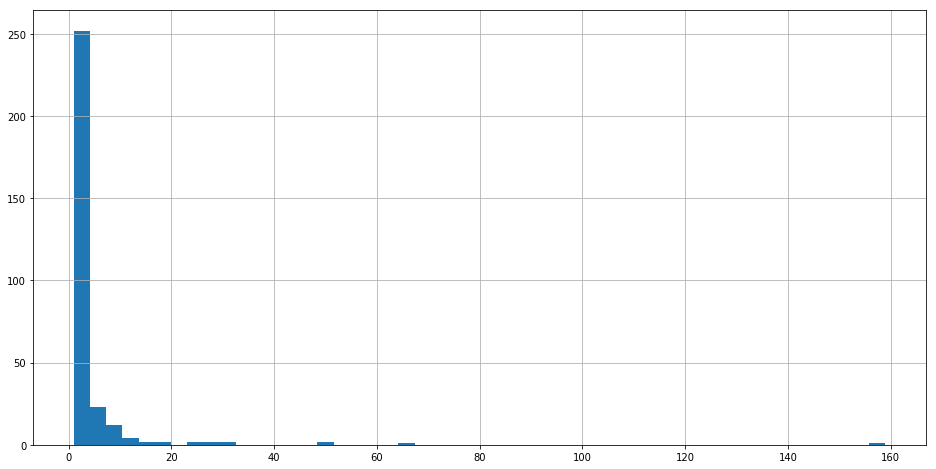

In [25]:
df_tsa_descgroup = df_tsa_proc.groupby(by='cln_2ndpass')['Amount'].count().sort_values(ascending=False)
df_tsa_descgroup.hist(bins=50, figsize=(16,8))

#### <font color=red>Inference Note:</font> 

- Most of the recurring transations are less than 10
- Bucket the data into different frquency class to represent the uneven distribution


In [26]:
df_tsa_descgroup.head()

cln_2ndpass
woolworths            159
ww petrol              67
chemist                49
anz insurance          49
hbf health limited     32
Name: Amount, dtype: int64

In [27]:
freq_bins = np.array([0, 2, 5, 9, 50, 1000])
freq_lables = ['onceoff', 'yearly', 'quaterly', 'monthly', 'weekly']
df_tsa_freq = pd.cut(df_tsa_descgroup, freq_bins, labels=freq_lables, right=False)
df_tsa_freq = df_tsa_freq.reset_index()
df_tsa_freq.columns = ['cln_2ndpass', 'freq_recurr']
df_tsa_freq.set_index('cln_2ndpass', inplace=True)

df_tsa_freq.head()

,freq_recurr
cln_2ndpass,
woolworths,weekly
ww petrol,weekly
chemist,monthly
anz insurance,monthly
hbf health limited,monthly


In [28]:
df_tsa_freq.freq_recurr.value_counts()

onceoff     178
yearly       74
quaterly     26
monthly      25
weekly        2
Name: freq_recurr, dtype: int64

In [29]:
df_tsa_freq.shape

(305, 1)

In [30]:
# Classify the main data frame with above recurring frequency categories

addbucket = lambda x: df_tsa_freq[df_tsa_freq.index == x].freq_recurr[0]

df_tsa_proc['trn_freq'] = df_tsa_proc['cln_2ndpass'].apply(addbucket)
df_tsa_proc.head()

,Amount,Description,Category,cln_1stpass,cln_2ndpass,trn_suburb,year,month,day,dayname,trn_freq
Date,,,,,,,,,,,
2019-02-04,-74.01,ANZ Insurance Sydney,Insurance,anz insurance sydney,anz insurance,sydney,2019,2,0,Monday,monthly
2019-02-04,-3.70,WOOLWORTHS 3089 DOCKLANDS,Grocery,woolworths docklands,woolworths,docklands,2019,2,0,Monday,weekly
2019-02-04,-38.00,KMART 1014 CAMPBELLFIELD,Homelife,kmart campbellfield,kmart,campbellfield,2019,2,0,Monday,monthly
2019-02-04,-40.11,WW PETROL 3592 CRAIGIEBURN,Fuel,ww petrol craigieburn,ww petrol,craigieburn,2019,2,0,Monday,weekly
2019-02-04,-31.60,WOOLWORTHS 3354 C/BURN CRAIGIEBURN,Grocery,woolworths c burn craigieburn,woolworths c burn,craigieburn,2019,2,0,Monday,quaterly


#### Backup 01 - Cleaned data
Backup cleaned data frame for furture use

In [31]:
df_tsa_proc.to_pickle("01f_cleaned_bank_statement_out.pkl")

In [32]:
df_tsa_proc.shape

(1193, 11)

# Exploratory Data Analysis

In [33]:
# Normalise the Amount coloum for future analysis

norm = lambda x: np.log(abs(x))
df_tsa_proc['norm_amount'] = df_tsa_proc.Amount.apply(norm)
df_tsa_proc.head()

,Amount,Description,Category,cln_1stpass,cln_2ndpass,trn_suburb,year,month,day,dayname,trn_freq,norm_amount
Date,,,,,,,,,,,,
2019-02-04,-74.01,ANZ Insurance Sydney,Insurance,anz insurance sydney,anz insurance,sydney,2019,2,0,Monday,monthly,4.304200
2019-02-04,-3.70,WOOLWORTHS 3089 DOCKLANDS,Grocery,woolworths docklands,woolworths,docklands,2019,2,0,Monday,weekly,1.308333
2019-02-04,-38.00,KMART 1014 CAMPBELLFIELD,Homelife,kmart campbellfield,kmart,campbellfield,2019,2,0,Monday,monthly,3.637586
2019-02-04,-40.11,WW PETROL 3592 CRAIGIEBURN,Fuel,ww petrol craigieburn,ww petrol,craigieburn,2019,2,0,Monday,weekly,3.691626
2019-02-04,-31.60,WOOLWORTHS 3354 C/BURN CRAIGIEBURN,Grocery,woolworths c burn craigieburn,woolworths c burn,craigieburn,2019,2,0,Monday,quaterly,3.453157


In [34]:
# Analyse only spending so, remove any credit card payments

df_tsa_exp = df_tsa_proc[df_tsa_proc.Amount < 0]

# covert the -ve amout to postive for analysis
df_tsa_exp['abs_amount'] = df_tsa_exp['Amount'].apply(abs)

C:\Users\dheep\Anaconda3\envs\dat10\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [35]:
df_tsa_exp.shape

(1158, 13)

monthly mean => 72.60312643678161
weekly mean => 31.476991150442476
quaterly mean => 62.001999999999995
onceoff mean => 131.08909604519775
yearly mean => 96.29888235294118


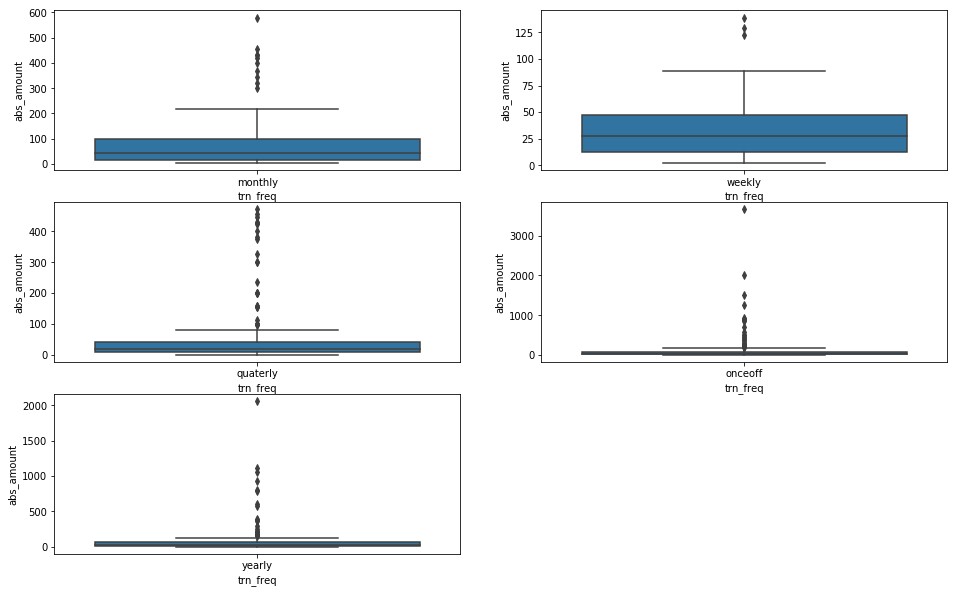

In [36]:
plt.rcParams['figure.figsize'] = (16, 10)

for n, freqclass in enumerate(df_tsa_exp.trn_freq.unique()):
    plt.subplot(3,2,n+1)
    sns.boxplot(x='trn_freq', y='abs_amount', data=df_tsa_exp[df_tsa_exp.trn_freq == freqclass])
    #print(f"*** {freqclass} ***")
    print(f"{freqclass} mean => {df_tsa_exp[df_tsa_exp.trn_freq == freqclass].abs_amount.mean()}")



In [37]:
#df_tsa_exp[df_tsa_exp.trn_freq == freqclass]

In [38]:
df_tsa_exp.pivot_table(values='abs_amount', index='trn_freq', aggfunc='describe' )

,25%,50%,75%,count,max,mean,min,std
trn_freq,,,,,,,,
monthly,16.105,44.600,97.4050,435.0,579.39,72.603126,3.70,77.896811
onceoff,12.490,25.000,80.0000,177.0,3664.86,131.089096,1.00,370.481424
quaterly,8.650,17.940,42.7100,150.0,471.05,62.002000,0.21,108.437578
weekly,12.020,27.005,46.9275,226.0,139.00,31.476991,2.10,23.756425
yearly,14.045,26.000,64.4125,170.0,2054.40,96.298882,3.20,231.768875


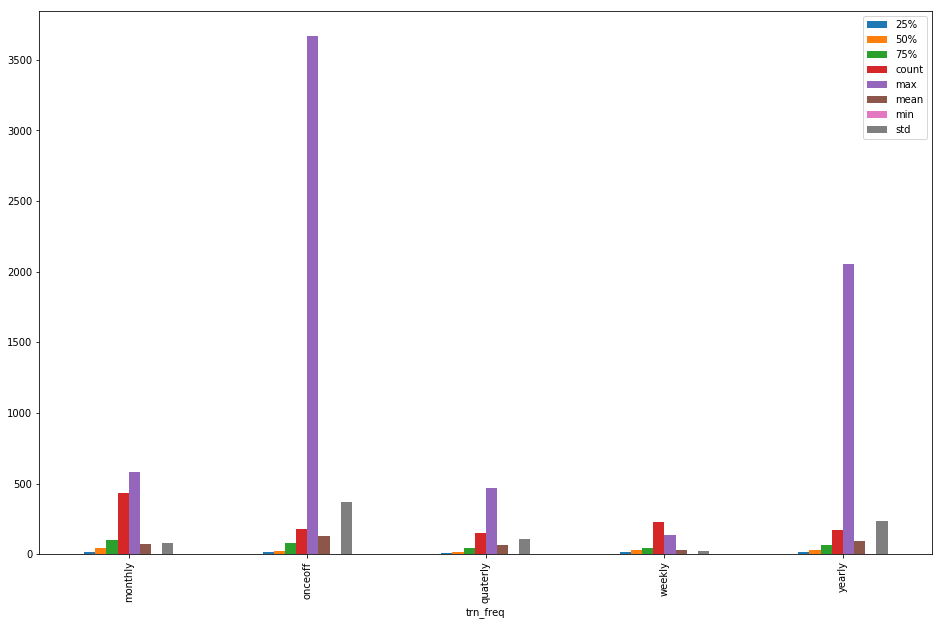

In [39]:
df_tsa_exp.pivot_table(values='abs_amount', index='trn_freq', aggfunc='describe' ).plot(kind='bar')

*** Oberservations ***
- Weekly, monthly and quaterly transactions has a stable pattern with low variance
- once-off and yearly transactions are highly varied

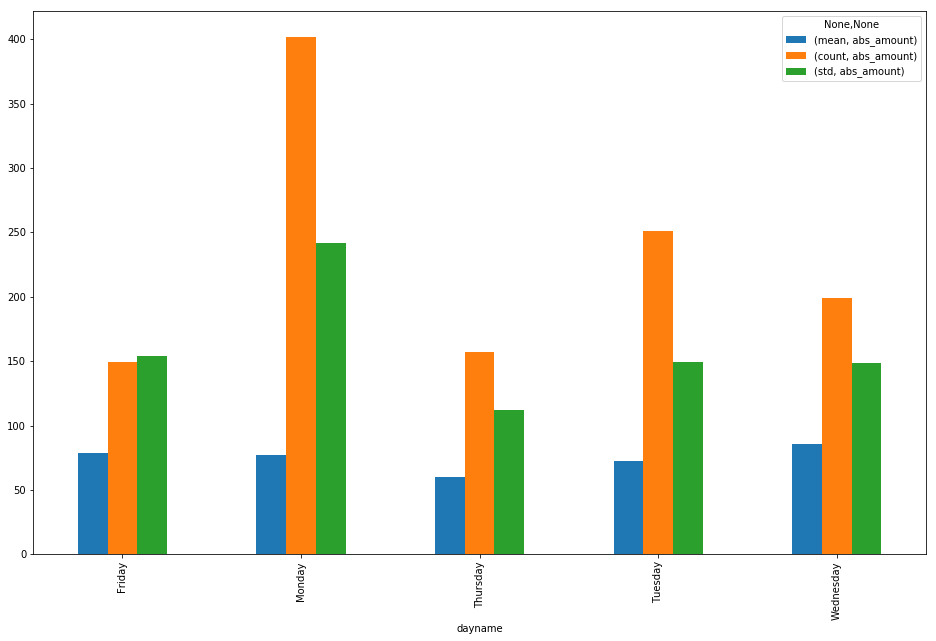

In [40]:
df_tsa_exp.pivot_table(values='abs_amount', index='dayname', aggfunc=['mean', 'count', 'std'] ).plot(kind='bar')

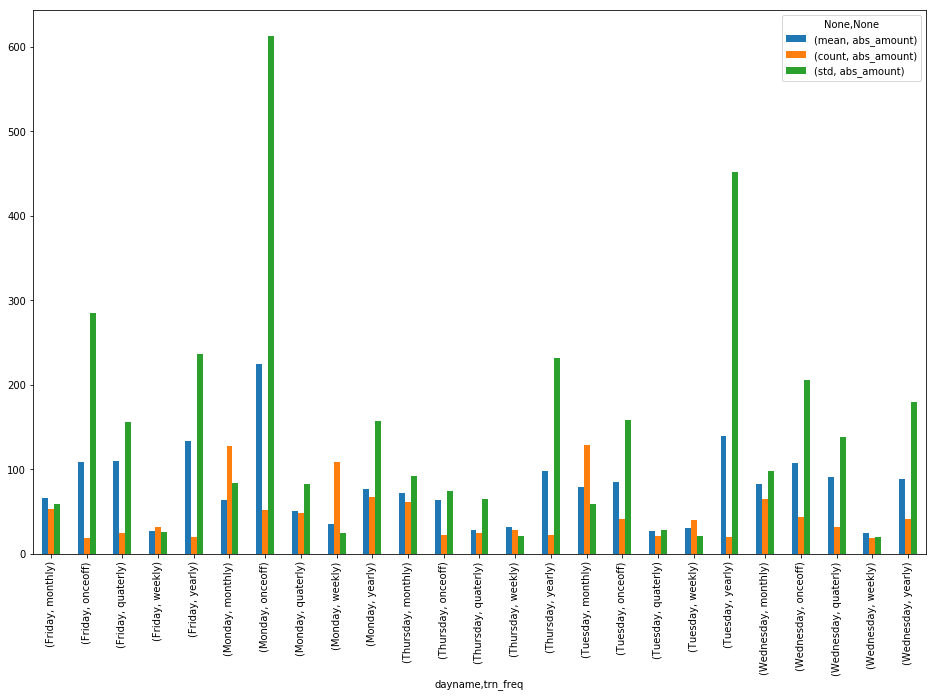

In [41]:
df_tsa_exp.pivot_table(values='abs_amount', index=['dayname', 'trn_freq'], aggfunc=['mean', 'count', 'std'] ).plot(kind='bar')

*** Observations: ***
    - Monday and Thursday seems to be the highly active days for spending
    
Note: There is a bias here. Looks like the banks transaction dates are delayed by two days.
- most of my spending is on weekends but monday seems predominant in the graph

In [42]:
#df_tsa_exp['trn_date'] = df_tsa_exp.index - timedelta(days=3)

In [43]:
df_tsa_exp.head()

,Amount,Description,Category,cln_1stpass,cln_2ndpass,trn_suburb,year,month,day,dayname,trn_freq,norm_amount,abs_amount
Date,,,,,,,,,,,,,
2019-02-04,-74.01,ANZ Insurance Sydney,Insurance,anz insurance sydney,anz insurance,sydney,2019,2,0,Monday,monthly,4.304200,74.01
2019-02-04,-3.70,WOOLWORTHS 3089 DOCKLANDS,Grocery,woolworths docklands,woolworths,docklands,2019,2,0,Monday,weekly,1.308333,3.70
2019-02-04,-38.00,KMART 1014 CAMPBELLFIELD,Homelife,kmart campbellfield,kmart,campbellfield,2019,2,0,Monday,monthly,3.637586,38.00
2019-02-04,-40.11,WW PETROL 3592 CRAIGIEBURN,Fuel,ww petrol craigieburn,ww petrol,craigieburn,2019,2,0,Monday,weekly,3.691626,40.11
2019-02-04,-31.60,WOOLWORTHS 3354 C/BURN CRAIGIEBURN,Grocery,woolworths c burn craigieburn,woolworths c burn,craigieburn,2019,2,0,Monday,quaterly,3.453157,31.60


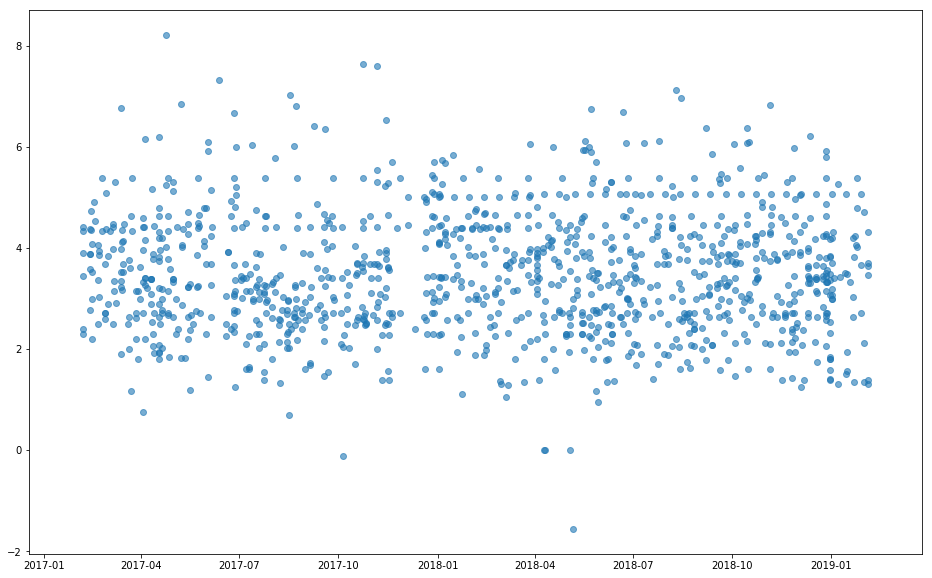

In [44]:
plt.scatter(x=df_tsa_exp.index, y='norm_amount', data=df_tsa_exp, alpha=0.6)

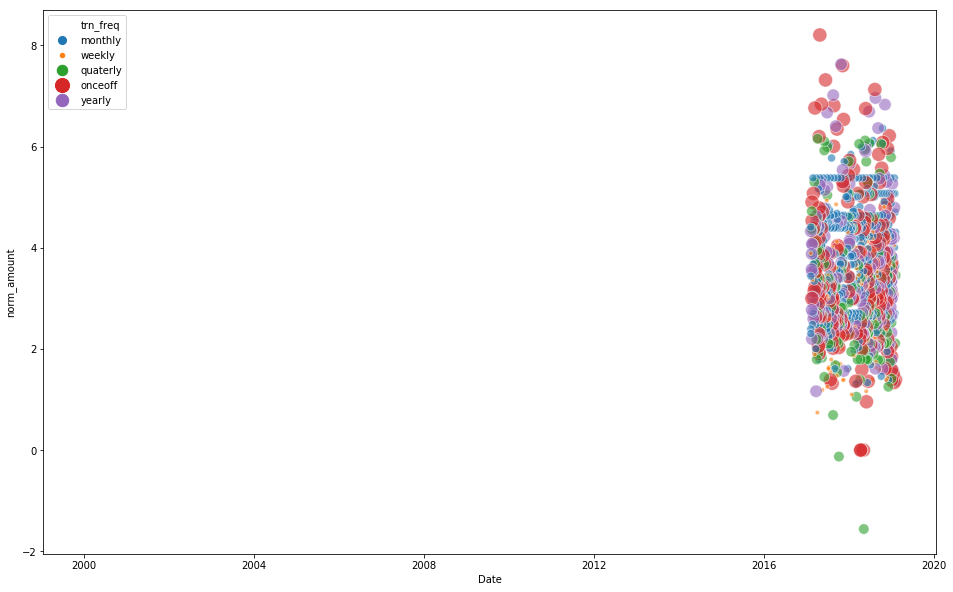

In [45]:
#plt.plot(x=xrange, y=np.array(df_anzts_exp.Amount))
#plt.rcParams["figure.figsize"] = (16,8) 
#plt.plot_date(x=df_tsa_exp.index, y=df_tsa_exp.norm_amount)
#ax, fig = plt.figure()

sns.scatterplot(x=df_tsa_exp.index, y='norm_amount', hue='trn_freq', data=df_tsa_exp, size='trn_freq', size_order=freq_lables, sizes=(20, 200), alpha=0.6)
# sns.scatterplot(x='Date', y='norm_amount', hue='trn_freq', data=df_temp, size='trn_freq', size_order=freq_lables, sizes=(20, 200), alpha=0.6)

***NOTES:***
- yearly and onceoff are more expensive than weekly and monthly transactions

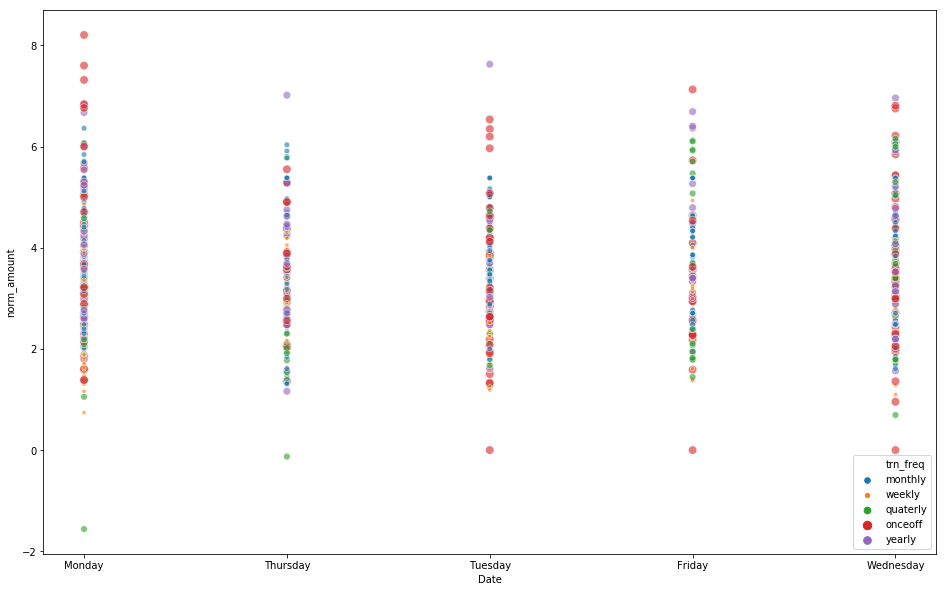

In [46]:
sns.scatterplot(x=df_tsa_exp.index.weekday_name, y='norm_amount', hue='trn_freq', data=df_tsa_exp, size='trn_freq', size_order=freq_lables, alpha=0.6)

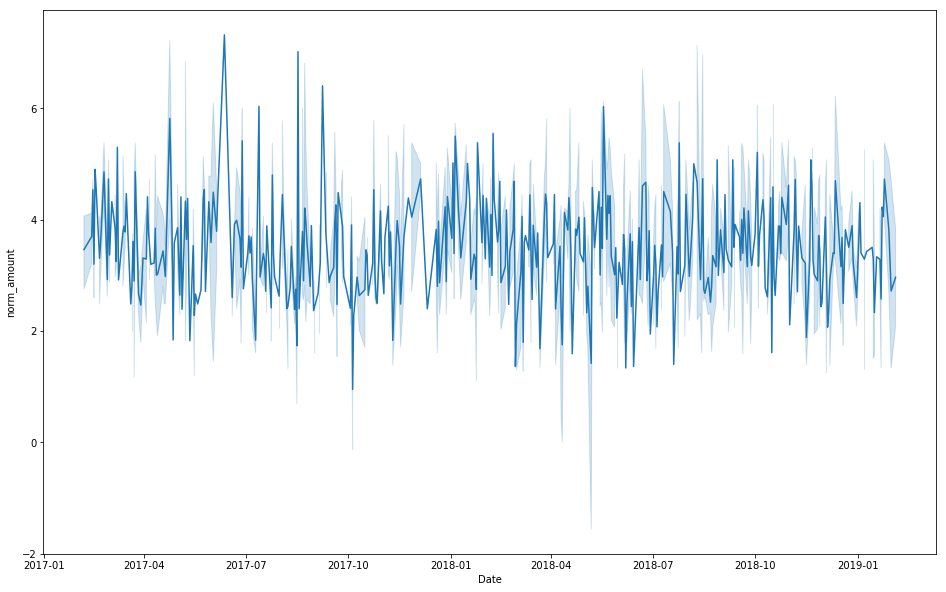

In [47]:
sns.lineplot(x=df_tsa_exp.index, y='norm_amount', data=df_tsa_exp)

monthly mean => 72.60312643678161
weekly mean => 31.476991150442476
quaterly mean => 62.001999999999995
onceoff mean => 131.08909604519775
yearly mean => 96.29888235294118


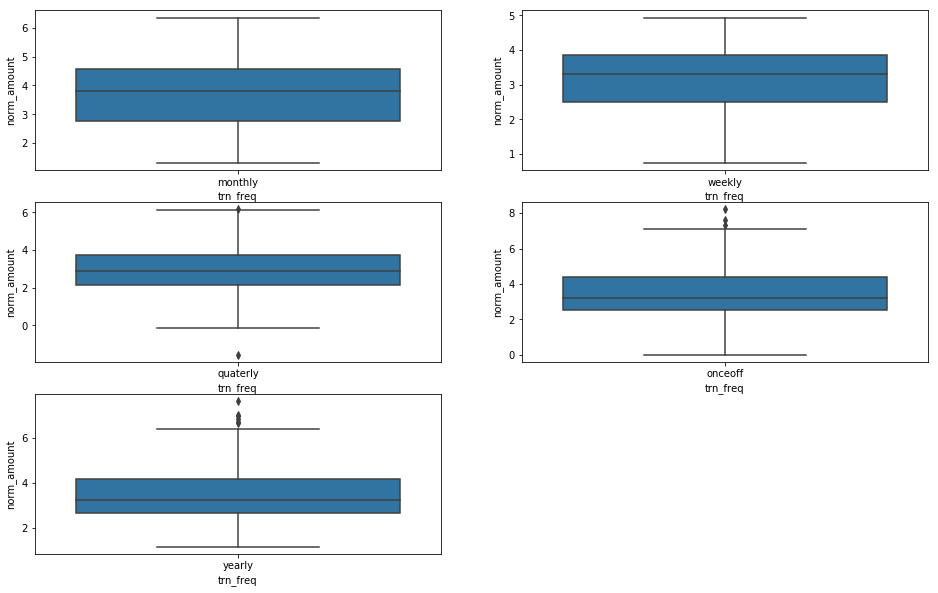

In [48]:
#plt.rcParams['figure.figsize'] = (16, 10)

for n, freqclass in enumerate(df_tsa_exp.trn_freq.unique()):
    plt.subplot(3,2,n+1)
    sns.boxplot(x='trn_freq', y='norm_amount', data=df_tsa_exp[df_tsa_exp.trn_freq == freqclass])
    #print(f"*** {freqclass} ***")
    print(f"{freqclass} mean => {df_tsa_exp[df_tsa_exp.trn_freq == freqclass].abs_amount.mean()}")



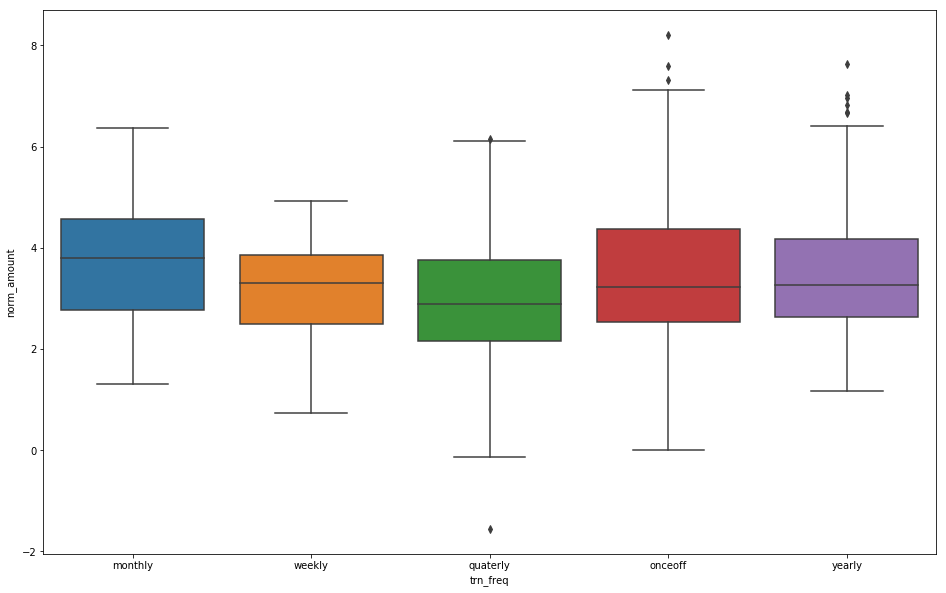

In [54]:
sns.boxplot(x=df_tsa_exp.trn_freq, y='norm_amount', data=df_tsa_exp) #, hue='trn_freq')

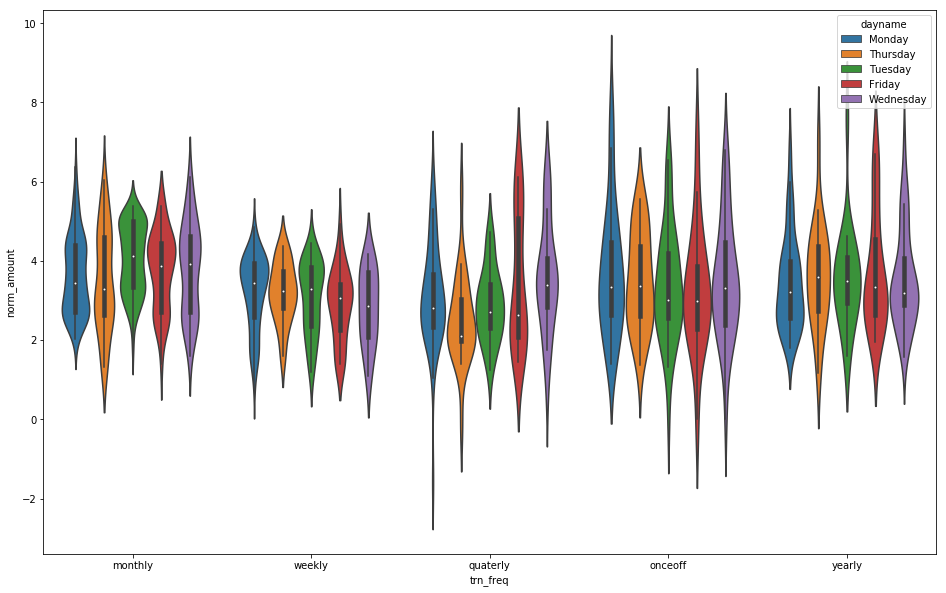

In [55]:
sns.violinplot(x='trn_freq', y='norm_amount', hue='dayname', data=df_tsa_exp)

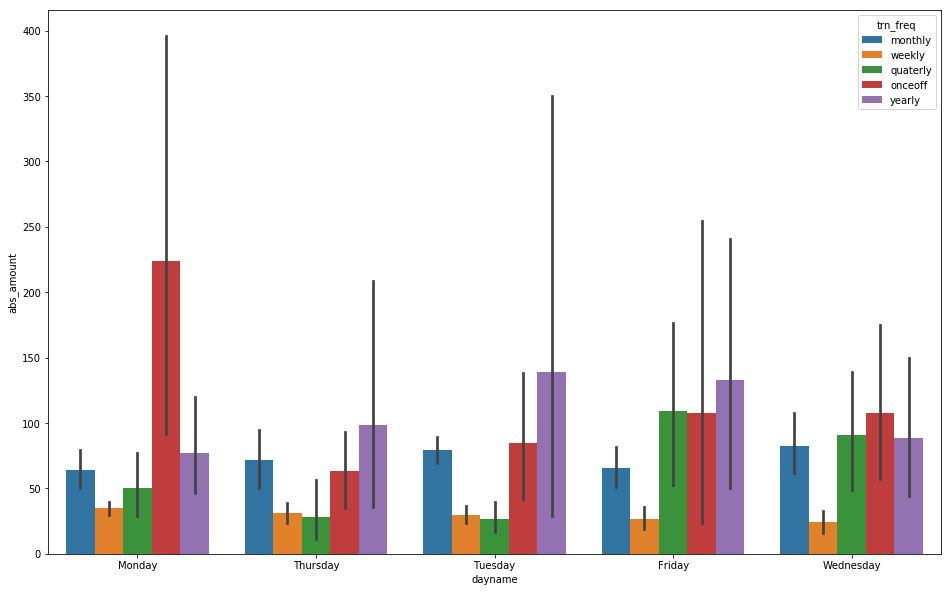

In [56]:
sns.barplot(x='dayname', y='abs_amount', hue='trn_freq', data=df_tsa_exp)

In [57]:
#sns.barplot(x='dayname', y='abs_amount', hue='trn_freq', data=df_tsa_exp.loc[df_tsa_exp.cln_2ndpass.str.contains('tgi')])

insurance, bills, dinning-out, groceries
40

In [58]:
df_tsa_exp.loc[df_tsa_exp.cln_2ndpass.str.contains('water')]

,Amount,Description,Category,cln_1stpass,cln_2ndpass,trn_suburb,year,month,day,dayname,trn_freq,norm_amount,abs_amount
Date,,,,,,,,,,,,,
2019-02-04,-4.00,ECLIPSE FRESHWATER MELBOURNE,Dinningout,eclipse freshwater melbourne,eclipse freshwater,melbourne,2019,2,0,Monday,onceoff,1.386294,4.00
2018-12-27,-45.02,YARRAVALLEYWATER YVOW MITCHAM,Water,yarravalleywater yvow mitcham,yarravalleywater yvow,mitcham,2018,12,3,Thursday,quaterly,3.807107,45.02
2018-12-27,-327.05,YARRAVALLEYWATER YVOW MITCHAM,Water,yarravalleywater yvow mitcham,yarravalleywater yvow,mitcham,2018,12,3,Thursday,quaterly,5.790113,327.05
2018-11-07,-121.69,YARRAVALLEYWATER WEB MITCHAM,Water,yarravalleywater web mitcham,yarravalleywater web,mitcham,2018,11,2,Wednesday,onceoff,4.801477,121.69
2018-10-03,-424.46,YARRAVALLEYWATER YVOW MITCHAM,Water,yarravalleywater yvow mitcham,yarravalleywater yvow,mitcham,2018,10,2,Wednesday,quaterly,6.050818,424.46
2018-09-21,-237.26,YARRAVALLEYWATER YVOW MITCHAM,Water,yarravalleywater yvow mitcham,yarravalleywater yvow,mitcham,2018,9,4,Friday,quaterly,5.469157,237.26
2018-06-25,-431.51,YARRAVALLEYWATER YVOW MITCHAM,Water,yarravalleywater yvow mitcham,yarravalleywater yvow,mitcham,2018,6,0,Monday,quaterly,6.067291,431.51
2018-06-25,-157.96,YARRAVALLEYWATER YVOW MITCHAM,Water,yarravalleywater yvow mitcham,yarravalleywater yvow,mitcham,2018,6,0,Monday,quaterly,5.062342,157.96
2018-03-28,-425.71,YARRAVALLEYWATER YVOW MITCHAM,Water,yarravalleywater yvow mitcham,yarravalleywater yvow,mitcham,2018,3,2,Wednesday,quaterly,6.053758,425.71


In [59]:
df_tsa_exp[df_tsa_exp.Description.str.contains('YARRA')]

,Amount,Description,Category,cln_1stpass,cln_2ndpass,trn_suburb,year,month,day,dayname,trn_freq,norm_amount,abs_amount
Date,,,,,,,,,,,,,
2018-12-27,-45.02,YARRAVALLEYWATER YVOW MITCHAM,Water,yarravalleywater yvow mitcham,yarravalleywater yvow,mitcham,2018,12,3,Thursday,quaterly,3.807107,45.02
2018-12-27,-327.05,YARRAVALLEYWATER YVOW MITCHAM,Water,yarravalleywater yvow mitcham,yarravalleywater yvow,mitcham,2018,12,3,Thursday,quaterly,5.790113,327.05
2018-11-07,-121.69,YARRAVALLEYWATER WEB MITCHAM,Water,yarravalleywater web mitcham,yarravalleywater web,mitcham,2018,11,2,Wednesday,onceoff,4.801477,121.69
2018-10-03,-424.46,YARRAVALLEYWATER YVOW MITCHAM,Water,yarravalleywater yvow mitcham,yarravalleywater yvow,mitcham,2018,10,2,Wednesday,quaterly,6.050818,424.46
2018-09-21,-237.26,YARRAVALLEYWATER YVOW MITCHAM,Water,yarravalleywater yvow mitcham,yarravalleywater yvow,mitcham,2018,9,4,Friday,quaterly,5.469157,237.26
2018-06-25,-431.51,YARRAVALLEYWATER YVOW MITCHAM,Water,yarravalleywater yvow mitcham,yarravalleywater yvow,mitcham,2018,6,0,Monday,quaterly,6.067291,431.51
2018-06-25,-157.96,YARRAVALLEYWATER YVOW MITCHAM,Water,yarravalleywater yvow mitcham,yarravalleywater yvow,mitcham,2018,6,0,Monday,quaterly,5.062342,157.96
2018-03-28,-425.71,YARRAVALLEYWATER YVOW MITCHAM,Water,yarravalleywater yvow mitcham,yarravalleywater yvow,mitcham,2018,3,2,Wednesday,quaterly,6.053758,425.71
2018-03-28,-156.22,YARRAVALLEYWATER YVOW MITCHAM,Water,yarravalleywater yvow mitcham,yarravalleywater yvow,mitcham,2018,3,2,Wednesday,quaterly,5.051265,156.22


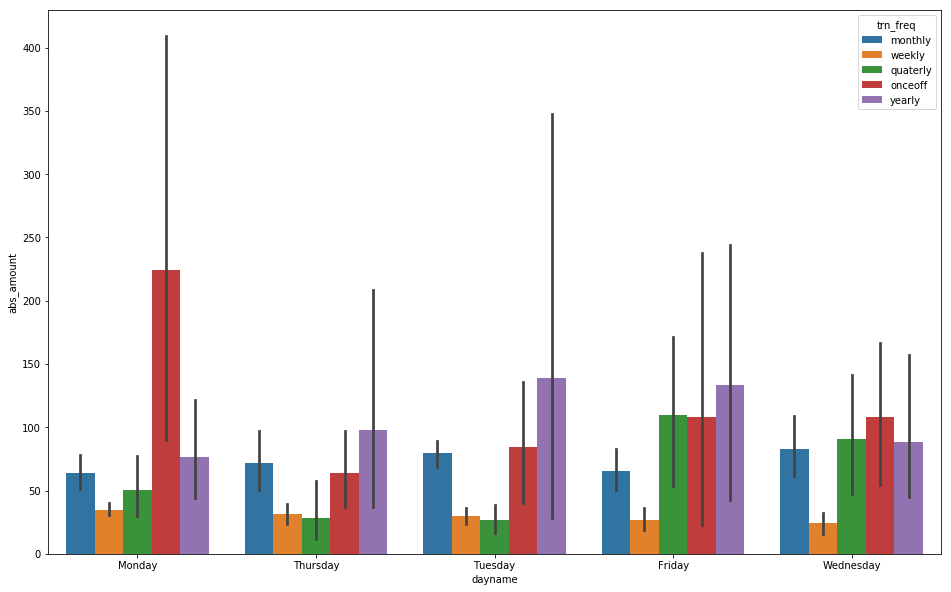

In [60]:
sns.barplot(x='dayname', y='abs_amount', hue='trn_freq', data=df_tsa_exp)

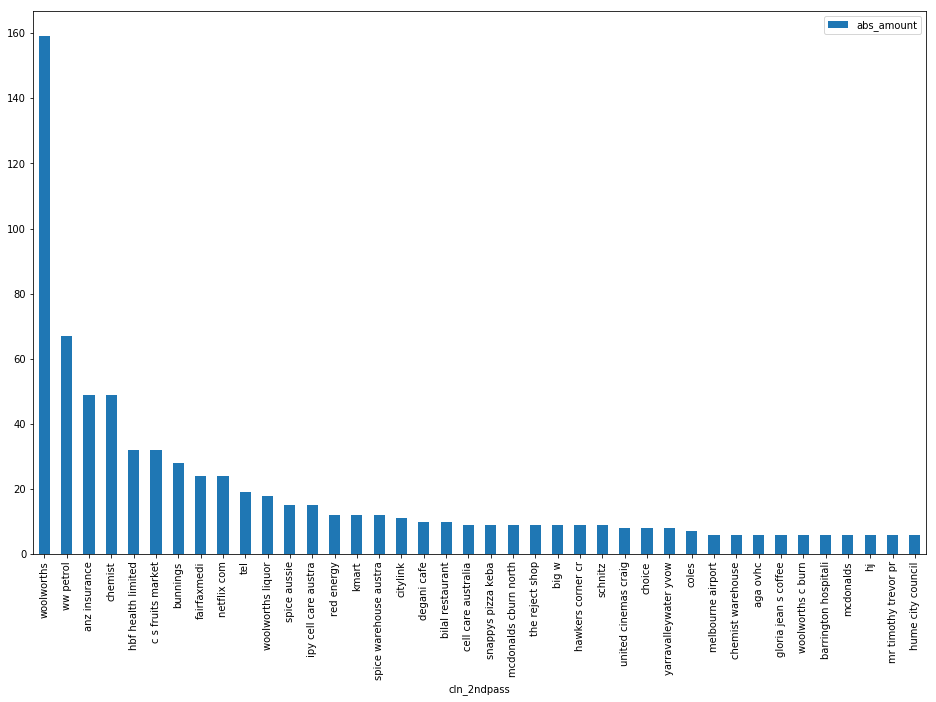

In [61]:
df_tsa_exp.pivot_table(values='abs_amount', index='cln_2ndpass', aggfunc='count').sort_values(by='abs_amount', ascending=False).head(40).plot(kind='bar')

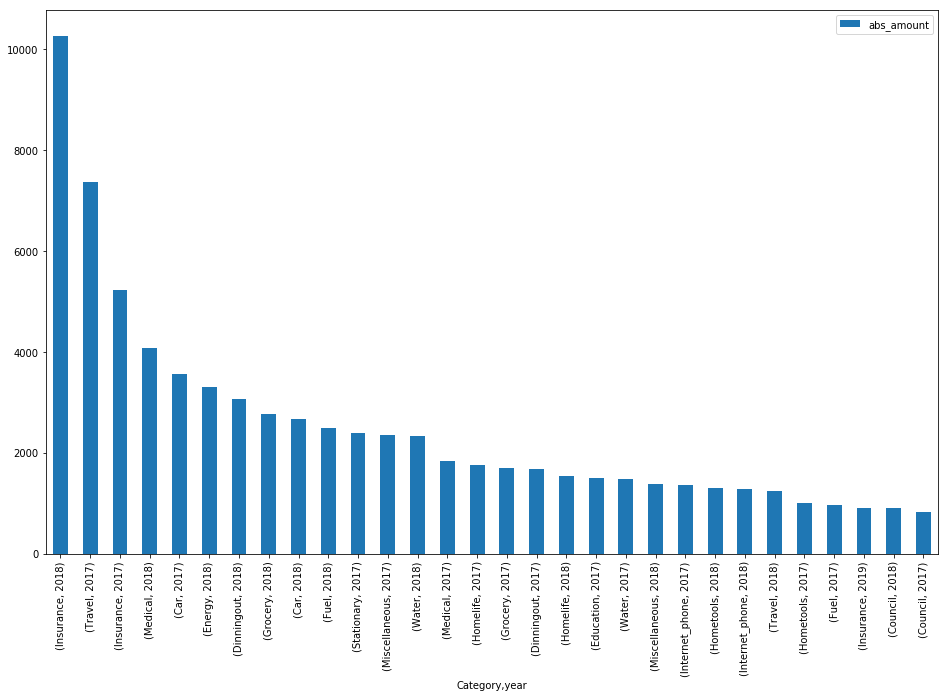

In [62]:
df_pivot_catsum_year = df_tsa_exp.pivot_table(values='abs_amount', index=['Category', 'year'], aggfunc='sum').sort_values(by='abs_amount', ascending=False).head(30)

df_pivot_catsum_year.plot(kind='bar')

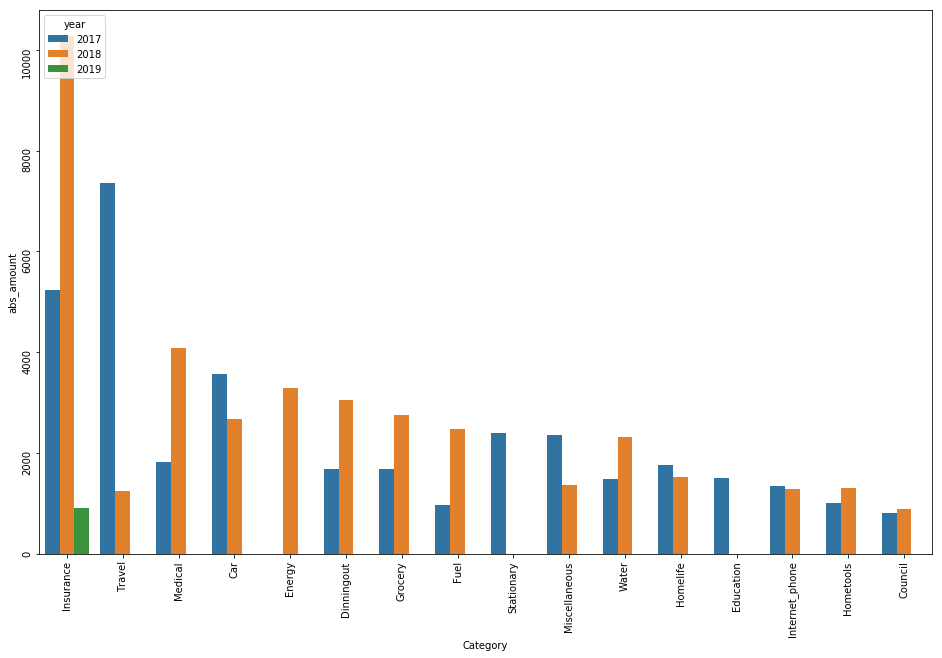

In [63]:

df_pivot_catsum_year = df_pivot_catsum_year.reset_index()
plt.tick_params(labelrotation=90)
sns.barplot(data=df_pivot_catsum_year, x='Category', y='abs_amount', hue='year')

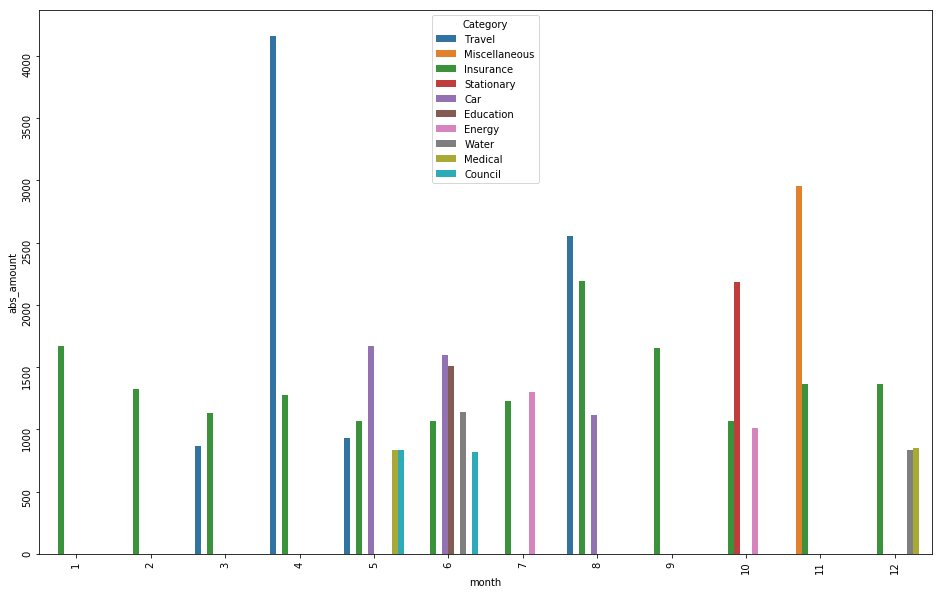

In [64]:
df_pivot_catsum_month = df_tsa_exp.pivot_table(values='abs_amount', index=['Category', 'month'], aggfunc='sum').sort_values(by='abs_amount', ascending=False).head(30)

df_pivot_catsum_month = df_pivot_catsum_month.reset_index()
plt.tick_params(labelrotation=90)
sns.barplot(data=df_pivot_catsum_month, x='month', y='abs_amount', hue='Category')

## Analyse with WordCloud

In [65]:
def concat_srsstr(df_sr, str_col):
    """ Concatenate the input Pandas series of the strings to single string
    """
    out_str = " ".join(x for x in df_sr[str_col])
    #[print(x) for x in df_sr['Description']]
    return out_str

In [66]:
from wordcloud import WordCloud

In [67]:
wc = WordCloud(background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

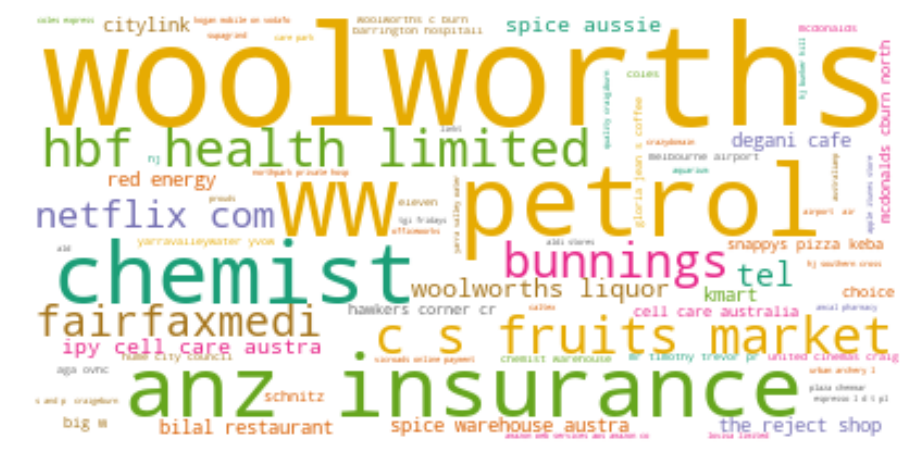

In [68]:
from collections import Counter
word_could_dict=Counter(list(df_tsa_exp['cln_2ndpass']))

#wordcloud = wc.generate(concat_srsstr(df_tsa_exp, 'cln_2ndpass'))
wordcloud = wc.generate_from_frequencies(word_could_dict)

plt.rcParams['figure.figsize'] = [16, 8]
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

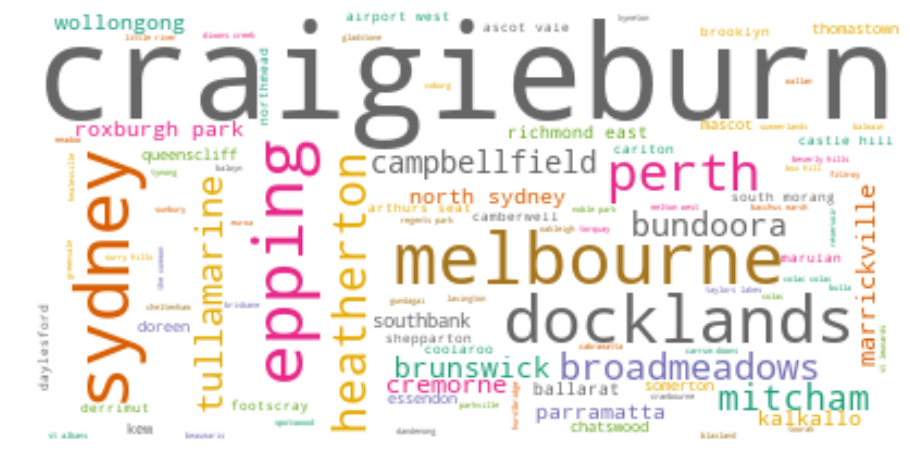

In [69]:
word_could_dict=Counter(list(df_tsa_exp['trn_suburb'].dropna()))

#wordcloud = wc.generate(concat_srsstr(df_tsa_exp, 'cln_2ndpass'))
wordcloud = wc.generate_from_frequencies(word_could_dict)

plt.rcParams['figure.figsize'] = [16, 8]
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [70]:
freq_lables
df_tsa_exp.loc[df_tsa_exp.trn_freq == 'onceoff']

,Amount,Description,Category,cln_1stpass,cln_2ndpass,trn_suburb,year,month,day,dayname,trn_freq,norm_amount,abs_amount
Date,,,,,,,,,,,,,
2019-02-04,-4.00,ECLIPSE FRESHWATER MELBOURNE,Dinningout,eclipse freshwater melbourne,eclipse freshwater,melbourne,2019,2,0,Monday,onceoff,1.386294,4.00
2019-01-22,-3.80,HUDSONS COFFEE MELBOURNE,Drinks,hudsons coffee melbourne,hudsons coffee,melbourne,2019,1,1,Tuesday,onceoff,1.335001,3.80
2019-01-15,-4.49,APPLE PTY LIMITED SYDNEY,Hometools,apple limited sydney,apple limited,sydney,2019,1,1,Tuesday,onceoff,1.501853,4.49
2019-01-02,-21.50,TGC CIRCULAR QUAY WETHERILL PAR,Parking,tgc circular quay wetherill par,tgc circular quay wetherill par,NaN,2019,1,2,Wednesday,onceoff,3.068053,21.50
2019-01-02,-40.40,LAXMINARAYAN PTY LTD PARRAMATTA,Miscellaneous,laxminarayan parramatta,laxminarayan,parramatta,2019,1,2,Wednesday,onceoff,3.698830,40.40
2018-12-31,-4.00,KEISHA CORPORATION P BAULKHAM HILL,Miscellaneous,keisha corporation p baulkham hill,keisha corporation p baulkham hill,NaN,2018,12,0,Monday,onceoff,1.386294,4.00
2018-12-31,-4.90,REBUS Q PTY LTD SYDNEY,Dinningout,rebus q sydney,rebus q,sydney,2018,12,0,Monday,onceoff,1.589235,4.90
2018-12-31,-6.35,WOOLWORTHS 1665 PARRAM PARRAMATTA,Grocery,woolworths parram parramatta,woolworths parram,parramatta,2018,12,0,Monday,onceoff,1.848455,6.35
2018-12-28,-35.00,SMP*Magic Memories Sydney,Gifts,smp magic memories sydney,smp magic memories,sydney,2018,12,4,Friday,onceoff,3.555348,35.00


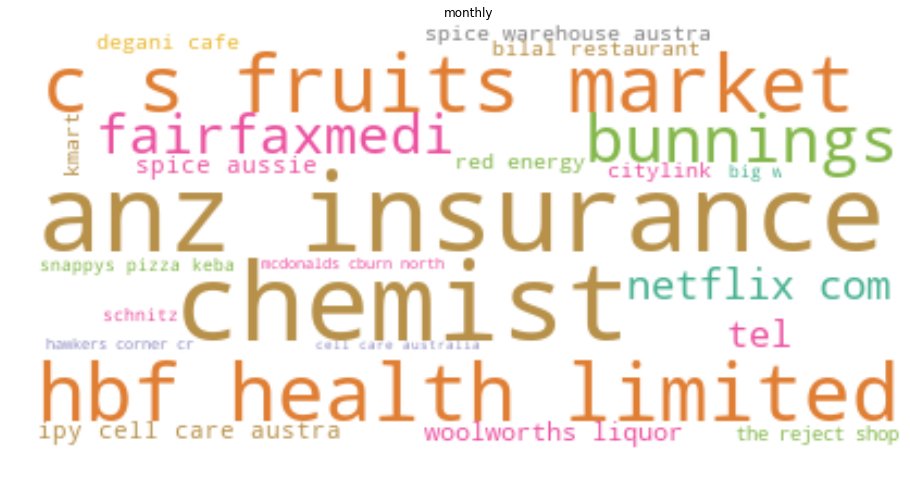

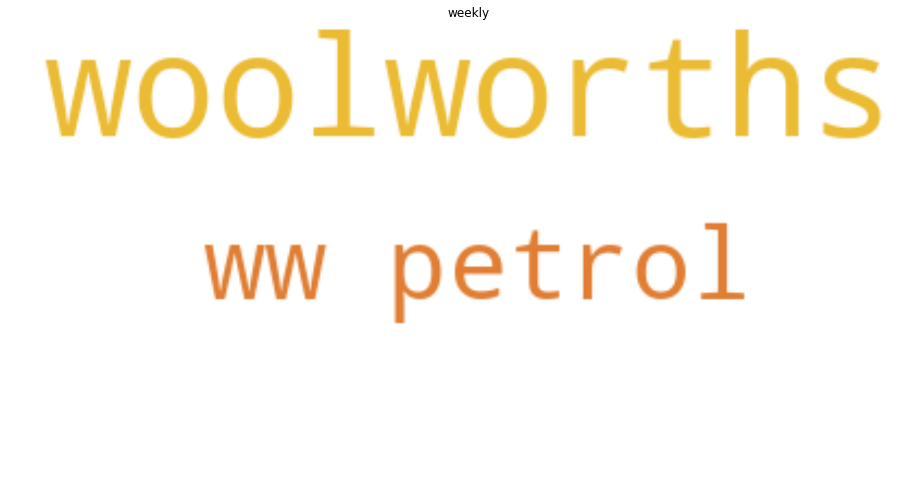

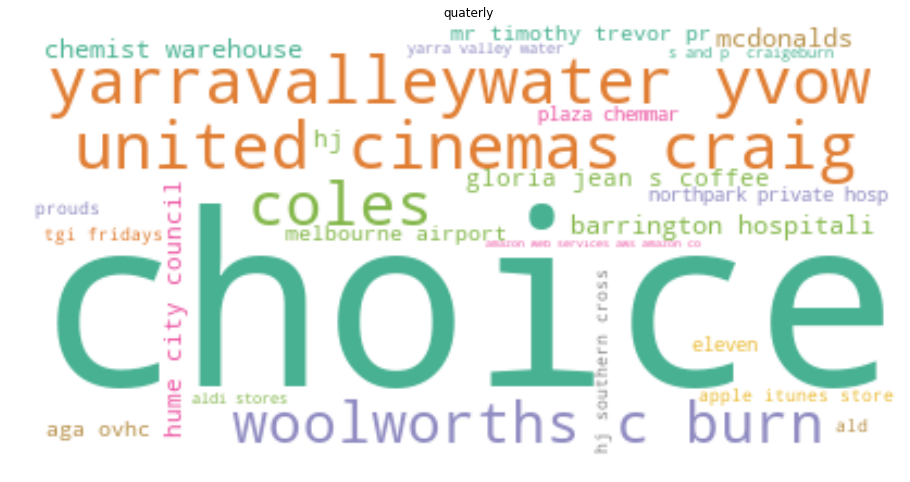

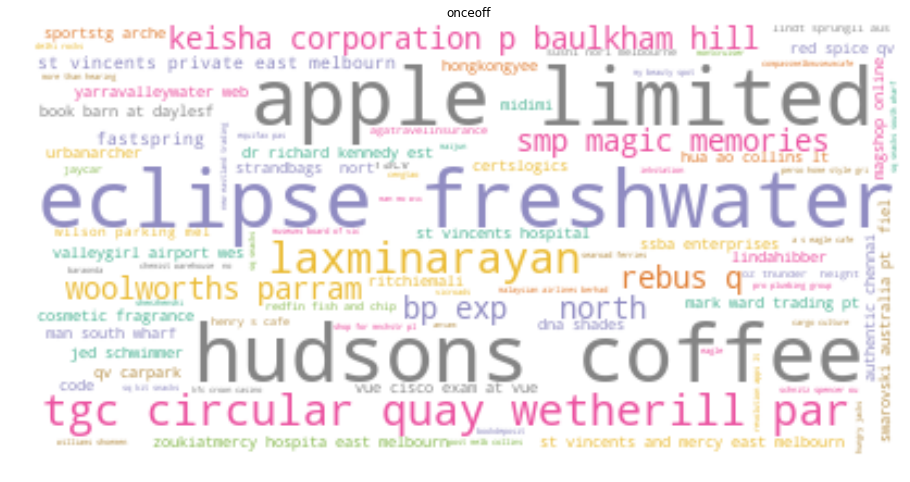

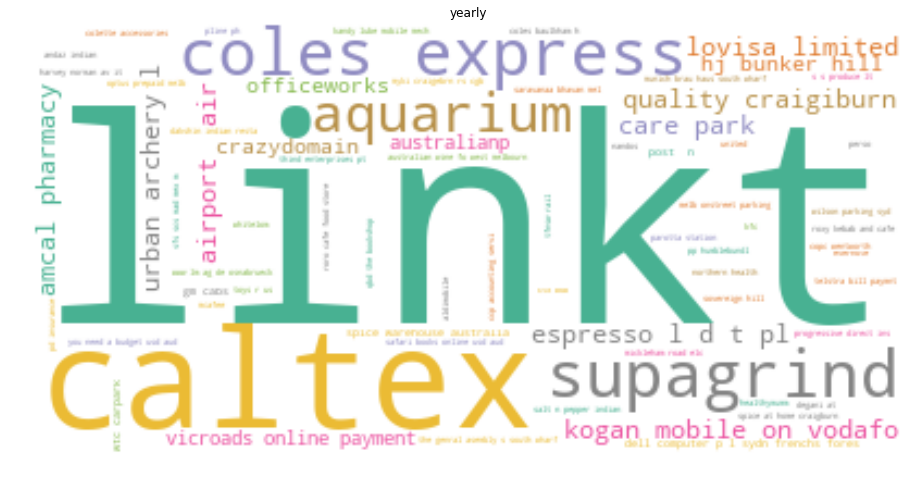

In [71]:
plt.rcParams['figure.figsize'] = [16, 8]



for n, freqclass in enumerate(df_tsa_exp.trn_freq.unique()):
    #plt.subplot(3,2,n+1)
    #sns.boxplot(x='trn_freq', y='abs_amount', data=df_tsa_exp[df_tsa_exp.trn_freq == freqclass])
    #print(f"*** {freqclass} ***")
    #print(f"{freqclass} mean => {df_tsa_exp[df_tsa_exp.trn_freq == freqclass].abs_amount.mean()}")
    
    #wordcloud = wc.generate(concat_srsstr(df_tsa_exp.loc[df_tsa_exp.trn_freq == freqclass], 'cln_2ndpass'))
    word_could_dict=Counter(list(df_tsa_exp.loc[df_tsa_exp.trn_freq == freqclass]['cln_2ndpass']))
    #wordcloud = wc.generate(list(df_tsa_exp.loc[df_tsa_exp.trn_freq == freqclass]['cln_2ndpass']))
    wordcloud = wc.generate_from_frequencies(word_could_dict)
    plt.rcParams['figure.figsize'] = [16, 8]
    plt.title(freqclass)
    plt.imshow(wordcloud, interpolation='bilinear', alpha=0.8)
    plt.axis("off")
    plt.show()



# Classification

### Preporcessing

In [72]:
df_tsa_proc.shape

(1193, 12)

In [73]:
# change the Data Frame to 
df_tsa_proc.reset_index(inplace=True)

In [74]:
df_tsa_proc.head()

,Date,Amount,Description,Category,cln_1stpass,cln_2ndpass,trn_suburb,year,month,day,dayname,trn_freq,norm_amount
0,2019-02-04,-74.01,ANZ Insurance Sydney,Insurance,anz insurance sydney,anz insurance,sydney,2019,2,0,Monday,monthly,4.304200
1,2019-02-04,-3.70,WOOLWORTHS 3089 DOCKLANDS,Grocery,woolworths docklands,woolworths,docklands,2019,2,0,Monday,weekly,1.308333
2,2019-02-04,-38.00,KMART 1014 CAMPBELLFIELD,Homelife,kmart campbellfield,kmart,campbellfield,2019,2,0,Monday,monthly,3.637586
3,2019-02-04,-40.11,WW PETROL 3592 CRAIGIEBURN,Fuel,ww petrol craigieburn,ww petrol,craigieburn,2019,2,0,Monday,weekly,3.691626
4,2019-02-04,-31.60,WOOLWORTHS 3354 C/BURN CRAIGIEBURN,Grocery,woolworths c burn craigieburn,woolworths c burn,craigieburn,2019,2,0,Monday,quaterly,3.453157


In [75]:
df_clean_anz = df_tsa_proc.drop(columns=['Date', 'Amount', 'Description', 'cln_1stpass', 'trn_suburb', 'year', 'month', 'day', 'dayname', 'trn_freq', 'norm_amount' ])

In [76]:
df_clean_anz.columns = ['Category', 'Description']
df_clean_anz.head()

,Category,Description
0,Insurance,anz insurance
1,Grocery,woolworths
2,Homelife,kmart
3,Fuel,ww petrol
4,Grocery,woolworths c burn


### Lable encoding

In [77]:
from sklearn.preprocessing import LabelEncoder

In [78]:
anzcat_en = LabelEncoder()
df_clean_anz['Catid']=anzcat_en.fit_transform(df_clean_anz.Category)

In [79]:
anzcat_en.classes_

array(['Book', 'Business', 'Car', 'Childcare', 'Council', 'Dinningout',
       'Drinks', 'Education', 'Energy', 'Entertainment', 'Fruit_veg',
       'Fuel', 'Garden', 'Gifts', 'Grocery', 'Grocery_indian', 'Hobby',
       'Homelife', 'Homeservice', 'Hometools', 'Insurance',
       'Internet_phone', 'Medical', 'Miscellaneous', 'Parking',
       'Repayment', 'Stationary', 'Subscription', 'Tax', 'Taxi', 'Toll',
       'Train', 'Travel', 'Water'], dtype=object)

In [80]:
df_clean_anz.head()

,Category,Description,Catid
0,Insurance,anz insurance,20
1,Grocery,woolworths,14
2,Homelife,kmart,17
3,Fuel,ww petrol,11
4,Grocery,woolworths c burn,14


### Word Tokeniser

In [81]:
from sklearn.feature_extraction import text

vectorizer = CountVectorizer()

cust_words = ['mr', 'pr', 'c', 'burn'] # words picked up from wordcloud analysis

stopwords = text.ENGLISH_STOP_WORDS.union(cust_words)

#options = "analyzer='word', lowercase=True, ngram_range=(1,3), binary=True, stop_words=suburb_found, min_df=2'"

cv = CountVectorizer(analyzer='word', lowercase=True, ngram_range=(1,3), binary=True, stop_words='english', min_df=2, max_df=0.8, max_features=200)
#cv = CountVectorizer(analyzer='word', lowercase=True, ngram_range=(1,2), binary=True, stop_words=None, min_df=2) #, max_features=100)
#cv = TfidfVectorizer(analyzer='word', lowercase=True, ngram_range=(1,1), binary=True, stop_words=stopwords, min_df=2) #, max_features=300)
#cv = vectorizer(options)

#cv = CountVectorizer(analyzer='word', lowercase=True, ngram_range=(1,2), binary=True, min_df=2) #, max_features=100)

In [82]:
cv_dtm = cv.fit_transform(df_clean_anz['Description'])

In [83]:
cv.get_feature_names()

['aga',
 'aga ovhc',
 'airasia',
 'airport',
 'ald',
 'aldi',
 'aldi stores',
 'amazon',
 'amazon web',
 'amazon web services',
 'anz',
 'anz insurance',
 'apple',
 'apple itunes',
 'apple itunes store',
 'aud',
 'aussie',
 'austra',
 'australia',
 'aws',
 'aws amazon',
 'barrington',
 'barrington hospitali',
 'big',
 'bilal',
 'bilal restaurant',
 'bp',
 'bunnings',
 'burn',
 'cafe',
 'care',
 'care austra',
 'care australia',
 'cburn',
 'cburn north',
 'cell',
 'cell care',
 'cell care austra',
 'cell care australia',
 'chemist',
 'chemist warehouse',
 'chemmar',
 'choice',
 'cinemas',
 'cinemas craig',
 'city',
 'city council',
 'citylink',
 'coffee',
 'coles',
 'com',
 'corner',
 'corner cr',
 'council',
 'cr',
 'craig',
 'craigeburn',
 'cross',
 'crown',
 'degani',
 'degani cafe',
 'energy',
 'enterprises',
 'fairfaxmedi',
 'fridays',
 'fruits',
 'fruits market',
 'gloria',
 'gloria jean',
 'gloria jean coffee',
 'hawkers',
 'hawkers corner',
 'hawkers corner cr',
 'hbf',
 'hbf he

In [84]:
#cv.vocabulary_
cv.stop_words_

{'accessories',
 'accounting',
 'accounting servi',
 'admission',
 'advantage',
 'advantage pas',
 'ag',
 'ag osnabrueck',
 'agatravelinsurance',
 'air',
 'airasia ak',
 'airasia ak oqimxe',
 'airasia pqmcnh',
 'airasia pqmcnh com',
 'airasia welvpb',
 'airasia welvpb com',
 'airasiax',
 'airasiax welvpb',
 'airasiax welvpb sepang',
 'airlines',
 'airlines berhad',
 'airport air',
 'airport wes',
 'ak',
 'ak oqimxe',
 'ak oqimxe sepang',
 'ak oqimxe singapore',
 'akay',
 'aldimobile',
 'alicesgarde',
 'amazon usd',
 'amazon usd aud',
 'amcal',
 'amcal pharmacy',
 'andaz',
 'andaz indian',
 'antam',
 'ao',
 'ao collins',
 'ao collins lt',
 'apple limited',
 'apps',
 'apps lt',
 'aquarium',
 'arche',
 'archery',
 'armstrong',
 'asembly',
 'asembly south',
 'asembly south wharf',
 'assi',
 'aston',
 'aston homes',
 'aus',
 'aust',
 'austral',
 'australia pt',
 'australia pt fiel',
 'australian',
 'australian wine',
 'australian wine fo',
 'australianp',
 'authentic',
 'authentic chennai',

In [85]:
df_dtm = pd.DataFrame(cv_dtm.toarray(), columns=cv.get_feature_names())
df_dtm.index = df_clean_anz.index
df_dtm.shape

(1193, 200)

In [86]:
df_clean_tonken = df_clean_anz.join(df_dtm)

In [87]:
df_clean_tonken.shape

(1193, 203)

## Prepare data

In [88]:
import math

norm = lambda x: np.log(abs(x))
#df_clean_tonken['norm_amount'] = df_clean_tonken.Amount.apply(norm)

X_src = df_clean_tonken.drop(columns=['Description', 'Category', 'Catid'])
y_src = df_clean_tonken['Catid']

print(X_src.shape, y_src.shape)

(1193, 200) (1193,)


In [529]:
X_train, X_test, y_train, y_test = train_test_split(X_src, y_src, test_size= 0.20, random_state=123, shuffle=False)

In [530]:
print(X_train.shape, X_test.shape)

(954, 200) (239, 200)


In [531]:
X_train.head()
X_train.shape

(954, 200)

## Classification

In [532]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [533]:
class_weights = df_clean_tonken.Catid.value_counts().sort_values(ascending=False).to_dict()
#class_weights

In [534]:
## find uniqclasses
uniqclass = df_clean_tonken.loc[:, 'Catid'].sort_values().unique()
len(uniqclass)

34

In [535]:
## DecisionTree classifier
#clf = DecisionTreeClassifier(max_depth=1000, criterion='entropy', splitter='random') #, class_weight=class_weights)
#clf = DecisionTreeClassifier(criterion='entropy', splitter='random')
#clf = DecisionTreeClassifier()

## Random Classifier
n_class = len(anzcat_en.classes_)
#clf = RandomForestClassifier(max_depth=500, max_features=n_class, random_state= 146, class_weight=class_weights)
#clf = RandomForestClassifier(max_depth=500, max_features=n_class, random_state= 146)
## Logistic Regression Classifier
#n_class = len(anzcat_en.classes_)
clf = LogisticRegression(random_state=122, multi_class='multinomial', max_iter=800, solver='lbfgs') #, class_weight=class_weights)

## Support Vector Machine
#clf = SVC(gamma='scale', decision_function_shape='ovo', probability=True, random_state=124) #, class_weight=class_weights)

In [536]:
## training for non-deep learning algoritham
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=800, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=122, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [537]:
## prediction for the non-deep learning algorithms
preds = clf.predict(X_test)

### Deeplearning

In [394]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import RMSprop

In [395]:
len(y_train.sort_values().unique())
#y_train.sort_values().unique()


34

In [396]:
## find uniqclasses
uniqclass = df_clean_tonken.loc[:, 'Catid'].sort_values().unique()
len(uniqclass)

34

Note: looks like sometimes the spliting is droping one of the records which is a rare event. 
- Always check if the split data shape matches unique classes

In [397]:
df_clean_tonken.loc[df_clean_tonken['Catid'] == 18]

,Category,Description,Catid,accessories,accounting,admission,advantage,ag,aga,agatravelinsurance,...,woolworths,wow,wtc,ww,www,yarra,yarravalleywater,yvow,zoos,zoukiatmercy
458,Homeservice,pro plumbing group,18,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [398]:
X_train.shape[1]
#X_test.shape

535

In [399]:
## Deeplearning Tensorflow classifier

clf = Sequential()

# hidden layer
clf.add(Dense(100, activation = 'relu', input_shape = (X_train.shape[1],)))

# 15 is the number of nodes we are setting
# relu - is the activation fucntion. This is will retrun 
# 0 if -ve
# same num if +ve

clf.add(Dropout(0.2))

# one more hidden layer
clf.add(Dense(340, activation = 'relu'))
clf.add(Dropout(0.2))

# one more hidden layer
clf.add(Dense(500, activation = 'relu'))
clf.add(Dropout(0.2))

# one more hidden layer
clf.add(Dense(500, activation = 'relu'))
clf.add(Dropout(0.2))

# one more hidden layer
clf.add(Dense(500, activation = 'relu'))
clf.add(Dropout(0.2))


# one more hidden layer
clf.add(Dense(300, activation = 'relu'))
clf.add(Dropout(0.2))


# add output layer
clf.add(Dense(len(uniqclass), activation = 'softmax'))

# softmax = classification we need to activation fuction to make sure the poorabablity iaadds to 1.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [400]:
clf.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               53600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 340)               34340     
_________________________________________________________________
dropout_2 (Dropout)          (None, 340)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 500)               170500    
_________________________________________________________________
dropout_3 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 500)               250500    
__________

In [401]:
## need to convery y_train to binary for deeplearning

y_deeptrain = keras.utils.to_categorical(y_train, len(uniqclass)).astype(int)
y_deeptrain[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [402]:
clf.compile(optimizer='rmsprop', loss = 'categorical_crossentropy', metrics= ['accuracy'])
early_stop = EarlyStopping(patience=10)
clf.fit(X_train, y_deeptrain, validation_split= 0.2, epochs=200, callbacks= [early_stop], shuffle=False)

Instructions for updating:
Use tf.cast instead.
Train on 763 samples, validate on 191 samples
Epoch 1/200
763/763 [==============================] - 3s 3ms/step - loss: 2.7557 - acc: 0.2294 - val_loss: 2.6518 - val_acc: 0.2199
Epoch 2/200
763/763 [==============================] - 0s 589us/step - loss: 1.9077 - acc: 0.4535 - val_loss: 2.1006 - val_acc: 0.4921
Epoch 3/200
763/763 [==============================] - 0s 532us/step - loss: 1.5664 - acc: 0.5518 - val_loss: 1.8886 - val_acc: 0.5707
Epoch 4/200
763/763 [==============================] - 0s 525us/step - loss: 1.2277 - acc: 0.6553 - val_loss: 1.7486 - val_acc: 0.5236
Epoch 5/200
763/763 [==============================] - 0s 557us/step - loss: 0.9958 - acc: 0.7038 - val_loss: 1.6633 - val_acc: 0.6178
Epoch 6/200
763/763 [==============================] - 0s 534us/step - loss: 0.8359 - acc: 0.7641 - val_loss: 1.5679 - val_acc: 0.6387
Epoch 7/200
763/763 [==============================] - 0s 548us/step - loss: 0.7349 - acc: 0.7824 

In [403]:
## Evaluation for deep learning

# convert y_test to binary
y_deeptest = keras.utils.to_categorical(y_test, len(uniqclass)).astype(int)

clf.evaluate(X_test, y_deeptest)

239/239 [==============================] - 0s 105us/step


[2.2461559163975418, 0.6945606709524179]

In [404]:
deeppred = clf.predict(X_test)

preds = [np.argmax(x) for x in deeppred]

In [538]:
df_out = pd.DataFrame(y_test)

In [539]:
df_out['actual_category'] = anzcat_en.inverse_transform(y_test)

In [540]:
df_out['preds'] = preds

In [541]:
df_out['predicted_category'] = anzcat_en.inverse_transform(preds)

In [542]:
clf.predict_proba(X_test)

array([[0.00247981, 0.00087862, 0.00363093, ..., 0.0012971 , 0.00150863,
        0.00139581],
       [0.00246235, 0.00087049, 0.00361217, ..., 0.00128579, 0.0014959 ,
        0.00138385],
       [0.00110238, 0.00039765, 0.00159789, ..., 0.00058401, 0.00067757,
        0.00062773],
       ...,
       [0.00719786, 0.00256282, 0.01020089, ..., 0.00377848, 0.00439178,
        0.00406479],
       [0.00107251, 0.00038145, 0.00156587, ..., 0.00056258, 0.00065401,
        0.00060526],
       [0.00091515, 0.00032562, 0.001337  , ..., 0.00048012, 0.00055808,
        0.00051652]])

In [543]:
metrics.accuracy_score(y_test, preds)

0.7405857740585774

In [544]:
#

In [545]:
#df_out['pred_prob'] = clf.predict_proba(X_test)
df_out

,Catid,actual_category,preds,predicted_category
954,15,Grocery_indian,15,Grocery_indian
955,10,Fruit_veg,10,Fruit_veg
956,14,Grocery,14,Grocery
957,14,Grocery,14,Grocery
958,17,Homelife,17,Homelife
959,14,Grocery,14,Grocery
960,13,Gifts,5,Dinningout
961,11,Fuel,11,Fuel
962,14,Grocery,14,Grocery
963,17,Homelife,17,Homelife


In [546]:
df_out['correct_pred'] = df_out.Catid == df_out.preds
df_out['Description'] = df_clean_anz.Description.iloc[X_test.index]
df_out['trn_freq'] = df_tsa_proc.trn_freq.iloc[X_test.index]
# print the wrong predictions
df_out.loc[df_out.correct_pred == False, :]

,Catid,actual_category,preds,predicted_category,correct_pred,Description,trn_freq
960,13,Gifts,5,Dinningout,False,colette accessories,yearly
964,21,Internet_phone,5,Dinningout,False,optus prepaid melb,yearly
971,17,Homelife,5,Dinningout,False,post n,yearly
992,29,Taxi,5,Dinningout,False,gm cabs,yearly
997,7,Education,27,Subscription,False,ine seattle usd aud,onceoff
999,29,Taxi,5,Dinningout,False,gm cabs,yearly
1000,13,Gifts,5,Dinningout,False,protectabag,onceoff
1002,32,Travel,5,Dinningout,False,airasia ak oqimxe sepang inr aud,onceoff
1003,17,Homelife,5,Dinningout,False,post n,yearly
1008,26,Stationary,5,Dinningout,False,officeworks,yearly


In [547]:
df_out.loc[df_out.correct_pred == False, :].groupby(by='trn_freq')['preds'].count().sort_values(ascending=False)

trn_freq
onceoff     28
yearly      27
quaterly     7
Name: preds, dtype: int64

In [548]:
df_out.loc[df_out.correct_pred == False, :].groupby(by='Description')['preds'].count().sort_values(ascending=False)

Description
aga ovhc                                 6
post  n                                  3
wtc carpark                              3
pline ph                                 3
gm cabs                                  2
telstra bill paymnt                      2
sovereign hill                           2
safari books online usd aud              2
hamzagodhra                              1
gumbuya park                             1
fred assi                                1
evernote                                 1
eleven                                   1
drivers group pl                         1
crown melb car park                      1
delaware north venue                     1
ine seattle usd aud                      1
crazydomain                              1
colette accessories                      1
coffee hq t sm caf p                     1
bp lt riv mb                             1
bp                                       1
baby bunting                             1

In [549]:
df_out[df_out.Description.str.contains('ald')]

,Catid,actual_category,preds,predicted_category,correct_pred,Description,trn_freq
970,5,Dinningout,5,Dinningout,True,mcdonalds cburn north,monthly
984,14,Grocery,14,Grocery,True,aldi stores,quaterly
1036,14,Grocery,14,Grocery,True,ald,quaterly
1068,5,Dinningout,5,Dinningout,True,mcdonalds cburn north,monthly
1069,5,Dinningout,5,Dinningout,True,mcdonalds,quaterly
1084,5,Dinningout,5,Dinningout,True,mcdonalds ballrt strt,onceoff
1086,5,Dinningout,5,Dinningout,True,mcdonalds cburn north,monthly
1136,14,Grocery,14,Grocery,True,aldi stores,quaterly


In [550]:
df_clean_tonken.iloc[184, [2,3,-1]]

Catid    21
aga       0
yvow      0
Name: 184, dtype: object

In [551]:
df_clean_tonken.iloc[831, [2,3,-1]]

Catid    21
aga       0
yvow      0
Name: 831, dtype: object

In [552]:
df_tsa_exp.pivot_table(values='abs_amount', index='Category', aggfunc='sum' ).sort_values(by='abs_amount', ascending=False)

,abs_amount
Category,
Insurance,16418.16
Travel,8609.14
Car,6233.56
Medical,5965.30
Dinningout,4920.96
Grocery,4559.06
Energy,4148.29
Water,3813.39
Miscellaneous,3775.85


In [553]:
df_out_analysis = df_tsa_exp
df_out_analysis.head()
# df_tsa_exp.pivot_table(values='abs_amount', index='Category', aggfunc='sum' ).sort_values(by='abs_amount', ascending=False)

,Amount,Description,Category,cln_1stpass,cln_2ndpass,trn_suburb,year,month,day,dayname,trn_freq,norm_amount,abs_amount
Date,,,,,,,,,,,,,
2019-02-04,-74.01,ANZ Insurance Sydney,Insurance,anz insurance sydney,anz insurance,sydney,2019,2,0,Monday,monthly,4.304200,74.01
2019-02-04,-3.70,WOOLWORTHS 3089 DOCKLANDS,Grocery,woolworths docklands,woolworths,docklands,2019,2,0,Monday,weekly,1.308333,3.70
2019-02-04,-38.00,KMART 1014 CAMPBELLFIELD,Homelife,kmart campbellfield,kmart,campbellfield,2019,2,0,Monday,monthly,3.637586,38.00
2019-02-04,-40.11,WW PETROL 3592 CRAIGIEBURN,Fuel,ww petrol craigieburn,ww petrol,craigieburn,2019,2,0,Monday,weekly,3.691626,40.11
2019-02-04,-31.60,WOOLWORTHS 3354 C/BURN CRAIGIEBURN,Grocery,woolworths c burn craigieburn,woolworths c burn,craigieburn,2019,2,0,Monday,quaterly,3.453157,31.60


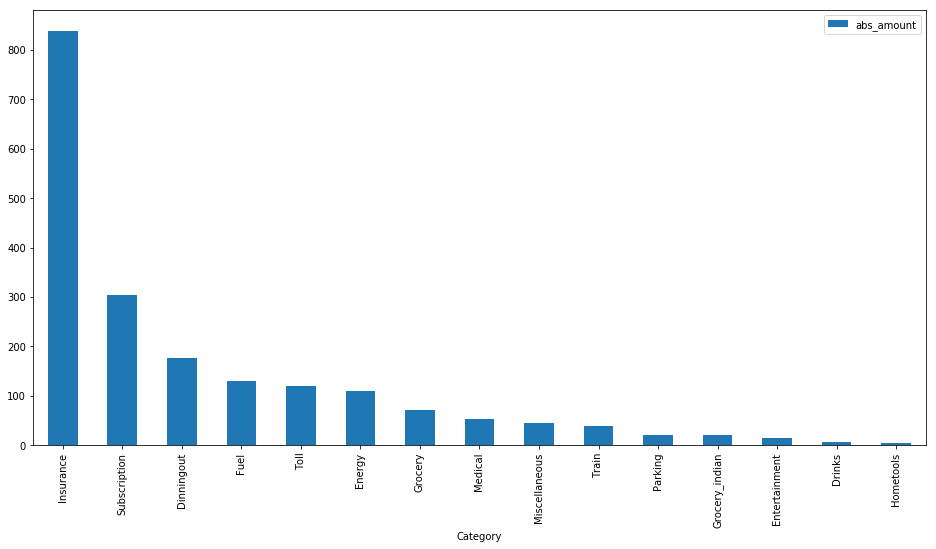

In [554]:


df_out_analysis['2019-01'].pivot_table(values='abs_amount', index='Category', aggfunc='sum' ).sort_values(by='abs_amount', ascending=False).plot(kind='bar')


In [555]:
df_out_analysis['2019-01'][df_out_analysis['2019-01'].Category == 'Subscription']

,Amount,Description,Category,cln_1stpass,cln_2ndpass,trn_suburb,year,month,day,dayname,trn_freq,norm_amount,abs_amount
Date,,,,,,,,,,,,,
2019-01-29,-15.00,PAYPAL *FAIRFAXMEDI 4029357733,Subscription,fairfaxmedi,fairfaxmedi,NaN,2019,1,1,Tuesday,monthly,2.708050,15.00
2019-01-07,-194.00,PAYPAL *HEALTHYMUMM 4029357733,Subscription,healthymumm,healthymumm,NaN,2019,1,0,Monday,yearly,5.267858,194.00
2019-01-04,-29.95,CHOICE MARRICKVILLE,Subscription,choice marrickville,choice,marrickville,2019,1,4,Friday,quaterly,3.399529,29.95
2019-01-02,-65.99,YOU NEED A BUDGET 801-6109169 45.00 U...,Subscription,you need a budget usd aud,you need a budget usd aud,NaN,2019,1,2,Wednesday,yearly,4.189503,65.99


Inference:
- Bit shocked to see why Subscription as the second highest spending
    - upon looking at the data it seems that I forgot cancel the healthmum subscription. It deteceted the anomaly in my spending

### Evaluation with unseen Data

In [745]:
df_newdoc = pd.read_csv("ANZ_feb2019_to_may2019.csv", date_parser=[0], dayfirst=True)
df_newdoc.dropna(axis=1, inplace=True)
df_newdoc.head()

,13/05/2019,-52.93,WOOLWORTHS 3354 C/BURN CRAIGIEBURN
0,13/05/2019,-9.30,WOOLWORTHS 3354 C/BURN CRAIGIEBURN
1,13/05/2019,-58.54,EG FUELCO 3592 CRAIGIE CRAIGIEBURN
2,10/05/2019,-79.95,EQUIFAX PAS NORTH SYDNEY
3,10/05/2019,-14.21,PAYPAL *UBER AU 4029357733
4,09/05/2019,-7.00,WOOLWORTHS 3354 C/BURN CRAIGIEBURN


In [746]:
df_newdoc.columns = ['Date', 'Amount', 'Description']

In [747]:
df_newdoc['Date'] = pd.to_datetime(df_newdoc.Date)


In [748]:
df_newdoc.dtypes

Date           datetime64[ns]
Amount                float64
Description            object
dtype: object

In [749]:
df_newdoc.shape

(148, 3)

In [750]:
df_newdoc['cln_1stpass'] = df_newdoc.Description.apply(clean1stpass)
df_newdoc.head()

,Date,Amount,Description,cln_1stpass
0,2019-05-13,-9.30,WOOLWORTHS 3354 C/BURN CRAIGIEBURN,woolworths c burn craigieburn
1,2019-05-13,-58.54,EG FUELCO 3592 CRAIGIE CRAIGIEBURN,eg fuelco craigie craigieburn
2,2019-10-05,-79.95,EQUIFAX PAS NORTH SYDNEY,equifax pas north sydney
3,2019-10-05,-14.21,PAYPAL *UBER AU 4029357733,uber au
4,2019-09-05,-7.00,WOOLWORTHS 3354 C/BURN CRAIGIEBURN,woolworths c burn craigieburn


In [751]:

suburbname = []
cln2_desc = []

for pstr in df_newdoc['cln_1stpass']:
    a,b = clean2ndpass(pstr)
    cln2_desc.append(a)
    suburbname.append(b)
    


In [752]:
df_newdoc['cln_2ndpass'] = cln2_desc
df_newdoc['trn_suburb'] = suburbname
#df_proc.drop(columns='trn_suburb', inplace=True)
df_newdoc.set_index('Date', inplace=True)
df_newdoc.head(15)

,Amount,Description,cln_1stpass,cln_2ndpass,trn_suburb
Date,,,,,
2019-05-13,-9.30,WOOLWORTHS 3354 C/BURN CRAIGIEBURN,woolworths c burn craigieburn,woolworths c burn,craigieburn
2019-05-13,-58.54,EG FUELCO 3592 CRAIGIE CRAIGIEBURN,eg fuelco craigie craigieburn,eg fuelco craigie,craigieburn
2019-10-05,-79.95,EQUIFAX PAS NORTH SYDNEY,equifax pas north sydney,equifax pas,north sydney
2019-10-05,-14.21,PAYPAL *UBER AU 4029357733,uber au,uber au,NaN
2019-09-05,-7.00,WOOLWORTHS 3354 C/BURN CRAIGIEBURN,woolworths c burn craigieburn,woolworths c burn,craigieburn
2019-09-05,-192.41,AMAZON MKTPLC AU SYDNEY SOUTH,amazon mktplc au sydney south,amazon mktplc au,sydney south
2019-07-05,-16.45,WOOLWORTHS 3089 DOCKLANDS,woolworths docklands,woolworths,docklands
2019-07-05,-30.00,IMAGE MELBOURNE PTY LTD,image melbourne,image,melbourne
2019-07-05,-171.10,HBF HEALTH LIMITED PERTH,hbf health limited perth,hbf health limited,perth


In [753]:
df_newdoc['year'] = df_newdoc.index.year
df_newdoc['month'] = df_newdoc.index.month
df_newdoc['day'] = df_newdoc.index.weekday
df_newdoc['dayname'] = df_newdoc.index.weekday_name
df_newdoc.head()

,Amount,Description,cln_1stpass,cln_2ndpass,trn_suburb,year,month,day,dayname
Date,,,,,,,,,
2019-05-13,-9.30,WOOLWORTHS 3354 C/BURN CRAIGIEBURN,woolworths c burn craigieburn,woolworths c burn,craigieburn,2019,5,0,Monday
2019-05-13,-58.54,EG FUELCO 3592 CRAIGIE CRAIGIEBURN,eg fuelco craigie craigieburn,eg fuelco craigie,craigieburn,2019,5,0,Monday
2019-10-05,-79.95,EQUIFAX PAS NORTH SYDNEY,equifax pas north sydney,equifax pas,north sydney,2019,10,5,Saturday
2019-10-05,-14.21,PAYPAL *UBER AU 4029357733,uber au,uber au,NaN,2019,10,5,Saturday
2019-09-05,-7.00,WOOLWORTHS 3354 C/BURN CRAIGIEBURN,woolworths c burn craigieburn,woolworths c burn,craigieburn,2019,9,3,Thursday


In [754]:
df_newdoc.reset_index(inplace=True)
df_newdoc.head()

,Date,Amount,Description,cln_1stpass,cln_2ndpass,trn_suburb,year,month,day,dayname
0,2019-05-13,-9.30,WOOLWORTHS 3354 C/BURN CRAIGIEBURN,woolworths c burn craigieburn,woolworths c burn,craigieburn,2019,5,0,Monday
1,2019-05-13,-58.54,EG FUELCO 3592 CRAIGIE CRAIGIEBURN,eg fuelco craigie craigieburn,eg fuelco craigie,craigieburn,2019,5,0,Monday
2,2019-10-05,-79.95,EQUIFAX PAS NORTH SYDNEY,equifax pas north sydney,equifax pas,north sydney,2019,10,5,Saturday
3,2019-10-05,-14.21,PAYPAL *UBER AU 4029357733,uber au,uber au,NaN,2019,10,5,Saturday
4,2019-09-05,-7.00,WOOLWORTHS 3354 C/BURN CRAIGIEBURN,woolworths c burn craigieburn,woolworths c burn,craigieburn,2019,9,3,Thursday


In [755]:
df_clean_newdoc = df_newdoc.drop(columns=['Date', 'Amount', 'Description', 'cln_1stpass', 'trn_suburb', 'year', 'month', 'day', 'dayname'])

In [756]:
df_clean_newdoc.columns = ['Description']
df_clean_newdoc.head()

,Description
0,woolworths c burn
1,eg fuelco craigie
2,equifax pas
3,uber au
4,woolworths c burn


In [757]:
# tokenise the description
df_clean_newdoc['Description']

0         woolworths c burn
1         eg fuelco craigie
2               equifax pas
3                   uber au
4         woolworths c burn
5          amazon mktplc au
6                woolworths
7                     image
8        hbf health limited
9                  bunnings
10     aldi stores craigieb
11         general assembly
12                    coles
13                  uber au
14            anz insurance
15     sushi nori melbourne
16              degani cafe
17                         
18     subway collin street
19        foxtel management
20             henry s cafe
21        woolworths c burn
22     gloria jean s coffee
23                    big w
24     united cinemas craig
25                 bunnings
26        woolworths c burn
27              fairfaxmedi
28                  chemist
29     ipy cell care austra
               ...         
118       c s fruits market
119         parotta station
120           anz insurance
121       woolworths liquor
122             offi

In [758]:
cv_newdoc_dtm = cv.transform(df_clean_newdoc['Description'])
cv_newdoc_dtm.shape

(148, 200)

In [759]:
df_clean_newdoc['Description'][0]

'woolworths c burn'

In [760]:
#cv.vocabulary_


In [761]:
df_newdoc_dtm = pd.DataFrame(cv_newdoc_dtm.toarray(), columns=cv.get_feature_names())
df_newdoc_dtm.index = df_clean_newdoc.index
df_newdoc_dtm.shape

(148, 200)

In [762]:
df_newdoc_dtm.head()

,aga,aga ovhc,airasia,airport,ald,aldi,aldi stores,amazon,amazon web,amazon web services,...,woolworths burn,woolworths liquor,ww,ww petrol,yarra,yarra valley,yarra valley water,yarravalleywater,yarravalleywater yvow,yvow
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [763]:
df_newdoc_tonken = df_clean_newdoc.join(df_newdoc_dtm)

In [764]:
df_newdoc_tonken.shape

(148, 201)

In [765]:
df_newdoc_tonken.head()

,Description,aga,aga ovhc,airasia,airport,ald,aldi,aldi stores,amazon,amazon web,...,woolworths burn,woolworths liquor,ww,ww petrol,yarra,yarra valley,yarra valley water,yarravalleywater,yarravalleywater yvow,yvow
0,woolworths c burn,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,eg fuelco craigie,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,equifax pas,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,uber au,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,woolworths c burn,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [781]:
df_newdoc_tonken.loc[:, df_newdoc_tonken.iloc[0] == 1]
#df_newdoc_tonken.loc[:, df_newdoc_tonken.iloc[0] == 1]

#df_newdoc_dtm.loc[:, df_newdoc_dtm.iloc[0] == 1]

,burn,woolworths,woolworths burn
0,1,1,1
1,0,0,0
2,0,0,0
3,0,0,0
4,1,1,1
5,0,0,0
6,0,1,0
7,0,0,0
8,0,0,0
9,0,0,0


In [767]:
#df_newdoc_tonken.loc[:, df_newdoc_tonken.iloc[0] == 1]
cv_newdoc_dtm.toarray()[0]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int64)

In [768]:
cv.get_feature_names()

['aga',
 'aga ovhc',
 'airasia',
 'airport',
 'ald',
 'aldi',
 'aldi stores',
 'amazon',
 'amazon web',
 'amazon web services',
 'anz',
 'anz insurance',
 'apple',
 'apple itunes',
 'apple itunes store',
 'aud',
 'aussie',
 'austra',
 'australia',
 'aws',
 'aws amazon',
 'barrington',
 'barrington hospitali',
 'big',
 'bilal',
 'bilal restaurant',
 'bp',
 'bunnings',
 'burn',
 'cafe',
 'care',
 'care austra',
 'care australia',
 'cburn',
 'cburn north',
 'cell',
 'cell care',
 'cell care austra',
 'cell care australia',
 'chemist',
 'chemist warehouse',
 'chemmar',
 'choice',
 'cinemas',
 'cinemas craig',
 'city',
 'city council',
 'citylink',
 'coffee',
 'coles',
 'com',
 'corner',
 'corner cr',
 'council',
 'cr',
 'craig',
 'craigeburn',
 'cross',
 'crown',
 'degani',
 'degani cafe',
 'energy',
 'enterprises',
 'fairfaxmedi',
 'fridays',
 'fruits',
 'fruits market',
 'gloria',
 'gloria jean',
 'gloria jean coffee',
 'hawkers',
 'hawkers corner',
 'hawkers corner cr',
 'hbf',
 'hbf he

## Prepare data

In [782]:
df_newdoc_tonken.head()

,Description,aga,aga ovhc,airasia,airport,ald,aldi,aldi stores,amazon,amazon web,...,woolworths burn,woolworths liquor,ww,ww petrol,yarra,yarra valley,yarra valley water,yarravalleywater,yarravalleywater yvow,yvow
0,woolworths c burn,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,eg fuelco craigie,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,equifax pas,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,uber au,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,woolworths c burn,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [769]:
import math

#norm = lambda x: np.log(abs(x))
#df_clean_tonken['norm_amount'] = df_clean_tonken.Amount.apply(norm)

X_eval = df_newdoc_tonken.drop(columns=['Description'])
X_eval.shape
X_eval.head()

,aga,aga ovhc,airasia,airport,ald,aldi,aldi stores,amazon,amazon web,amazon web services,...,woolworths burn,woolworths liquor,ww,ww petrol,yarra,yarra valley,yarra valley water,yarravalleywater,yarravalleywater yvow,yvow
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [827]:
X_eval.loc[:, X_eval.iloc[87] == 1]

""
0
1
2
3
4
5
6
7
8
9


In [784]:
# predictions
newdoc_preds = clf.predict(X_eval)

# newdoc_preds = 

In [785]:
## deeplearning prediction
#newdoc_deeppred = clf.predict(X_eval)
#newdoc_preds = [np.argmax(x) for x in newdoc_deeppred]

In [786]:
newdoc_preds

array([14,  5,  5,  5, 14,  5, 14,  5, 20, 19, 14,  5, 14,  5, 20,  5,  6,
        5,  5,  5,  5, 14,  6, 17,  9, 19, 14, 27, 22, 20,  5, 20, 14, 22,
       25, 20,  5,  5,  9,  5,  4, 22,  5,  5, 13, 14,  5, 14,  5,  5, 14,
       20, 14,  5, 25,  5,  5, 27, 20,  5,  5,  5,  5,  5,  5,  5,  5,  8,
        8, 33, 33, 33, 20, 20, 19, 27, 20, 11, 17, 14, 25, 22,  5, 11, 14,
       22,  9,  5,  5,  9,  9,  5, 13, 14, 20, 14,  5,  5,  5, 11, 14, 22,
       20,  5, 14, 11, 13,  5, 14, 22,  5,  5, 20,  5, 14,  5, 27, 20, 10,
        5, 20,  6,  5, 14, 14,  5, 21, 22,  5, 22, 22,  9, 11, 14, 25,  5,
        5,  5,  9,  5,  5, 14, 13,  5,  5, 20,  5,  5])

In [787]:
#df_newdoc_out = pd.DataFrame(df_clean_newdoc)

df_newdoc_out = pd.DataFrame(df_newdoc.drop(columns=['cln_1stpass']))
df_newdoc_out.head()

,Date,Amount,Description,cln_2ndpass,trn_suburb,year,month,day,dayname
0,2019-05-13,-9.30,WOOLWORTHS 3354 C/BURN CRAIGIEBURN,woolworths c burn,craigieburn,2019,5,0,Monday
1,2019-05-13,-58.54,EG FUELCO 3592 CRAIGIE CRAIGIEBURN,eg fuelco craigie,craigieburn,2019,5,0,Monday
2,2019-10-05,-79.95,EQUIFAX PAS NORTH SYDNEY,equifax pas,north sydney,2019,10,5,Saturday
3,2019-10-05,-14.21,PAYPAL *UBER AU 4029357733,uber au,NaN,2019,10,5,Saturday
4,2019-09-05,-7.00,WOOLWORTHS 3354 C/BURN CRAIGIEBURN,woolworths c burn,craigieburn,2019,9,3,Thursday


In [788]:
#df_out['actual_category'] = anzcat_en.inverse_transform(y_test)

In [796]:
df_newdoc_out.cln_2ndpass.str.contains('')

0      True
1      True
2      True
3      True
4      True
5      True
6      True
7      True
8      True
9      True
10     True
11     True
12     True
13     True
14     True
15     True
16     True
17     True
18     True
19     True
20     True
21     True
22     True
23     True
24     True
25     True
26     True
27     True
28     True
29     True
       ... 
118    True
119    True
120    True
121    True
122    True
123    True
124    True
125    True
126    True
127    True
128    True
129    True
130    True
131    True
132    True
133    True
134    True
135    True
136    True
137    True
138    True
139    True
140    True
141    True
142    True
143    True
144    True
145    True
146    True
147    True
Name: cln_2ndpass, Length: 148, dtype: bool

In [789]:
df_newdoc_out['preds'] = newdoc_preds

In [790]:
df_newdoc_out['predicted_category'] = anzcat_en.inverse_transform(newdoc_preds)

In [809]:
# prediction probablity distribution
clf.predict_proba(X_eval)

df_propdist = pd.DataFrame(clf.predict_proba(X_eval), columns=anzcat_en.classes_)
df_propdist.head()

,Book,Business,Car,Childcare,Council,Dinningout,Drinks,Education,Energy,Entertainment,...,Parking,Repayment,Stationary,Subscription,Tax,Taxi,Toll,Train,Travel,Water
0,0.000739,0.000268,0.001067,0.000137,0.000147,0.004503,0.004682,0.000390,0.000282,0.001305,...,0.001003,0.000300,0.001270,0.001482,0.000393,0.000265,0.000784,0.000393,0.000456,0.000423
1,0.017162,0.005541,0.026882,0.002747,0.002958,0.270955,0.027981,0.008312,0.005838,0.034868,...,0.024853,0.006246,0.033652,0.041380,0.008381,0.005467,0.018410,0.008381,0.009867,0.009070
2,0.017162,0.005541,0.026882,0.002747,0.002958,0.270955,0.027981,0.008312,0.005838,0.034868,...,0.024853,0.006246,0.033652,0.041380,0.008381,0.005467,0.018410,0.008381,0.009867,0.009070
3,0.017162,0.005541,0.026882,0.002747,0.002958,0.270955,0.027981,0.008312,0.005838,0.034868,...,0.024853,0.006246,0.033652,0.041380,0.008381,0.005467,0.018410,0.008381,0.009867,0.009070
4,0.000739,0.000268,0.001067,0.000137,0.000147,0.004503,0.004682,0.000390,0.000282,0.001305,...,0.001003,0.000300,0.001270,0.001482,0.000393,0.000265,0.000784,0.000393,0.000456,0.000423


In [816]:
df_propdist.sum() < 0.2

Book              False
Business          False
Car               False
Childcare          True
Council           False
Dinningout        False
Drinks            False
Education         False
Energy            False
Entertainment     False
Fruit_veg         False
Fuel              False
Garden            False
Gifts             False
Grocery           False
Grocery_indian    False
Hobby             False
Homelife          False
Homeservice        True
Hometools         False
Insurance         False
Internet_phone    False
Medical           False
Miscellaneous     False
Parking           False
Repayment         False
Stationary        False
Subscription      False
Tax               False
Taxi              False
Toll              False
Train             False
Travel            False
Water             False
dtype: bool

In [792]:
df_newdoc_out.head()

,Date,Amount,Description,cln_2ndpass,trn_suburb,year,month,day,dayname,preds,predicted_category
0,2019-05-13,-9.30,WOOLWORTHS 3354 C/BURN CRAIGIEBURN,woolworths c burn,craigieburn,2019,5,0,Monday,14,Grocery
1,2019-05-13,-58.54,EG FUELCO 3592 CRAIGIE CRAIGIEBURN,eg fuelco craigie,craigieburn,2019,5,0,Monday,5,Dinningout
2,2019-10-05,-79.95,EQUIFAX PAS NORTH SYDNEY,equifax pas,north sydney,2019,10,5,Saturday,5,Dinningout
3,2019-10-05,-14.21,PAYPAL *UBER AU 4029357733,uber au,NaN,2019,10,5,Saturday,5,Dinningout
4,2019-09-05,-7.00,WOOLWORTHS 3354 C/BURN CRAIGIEBURN,woolworths c burn,craigieburn,2019,9,3,Thursday,14,Grocery


In [797]:
df_newdoc_out.groupby(by=['cln_2ndpass', 'predicted_category']).count()

,,Date,Amount,Description,trn_suburb,year,month,day,dayname,preds
cln_2ndpass,predicted_category,,,,,,,,,
,Dinningout,2,2,2,0,2,2,2,2,2
aldi stores craigieb,Grocery,1,1,1,1,1,1,1,1,1
amazon mktplc au,Dinningout,1,1,1,1,1,1,1,1,1
anz insurance,Insurance,6,6,6,6,6,6,6,6,6
apple limited,Gifts,4,4,4,4,4,4,4,4,4
barrington hospitali,Medical,3,3,3,3,3,3,3,3,3
big w,Homelife,2,2,2,2,2,2,2,2,2
bilal restaurant,Dinningout,2,2,2,2,2,2,2,2,2
bunnings,Hometools,3,3,3,3,3,3,3,3,3


In [798]:
df_newdoc_out[df_newdoc_out.Description.str.contains('YARRA')]

,Date,Amount,Description,cln_2ndpass,trn_suburb,year,month,day,dayname,preds,predicted_category
69,2019-03-28,-155.43,YARRAVALLEYWATER YVOW MITCHAM,yarravalleywater yvow,mitcham,2019,3,3,Thursday,33,Water
70,2019-03-28,-320.66,YARRAVALLEYWATER YVOW MITCHAM,yarravalleywater yvow,mitcham,2019,3,3,Thursday,33,Water
71,2019-03-28,-155.84,YARRAVALLEYWATER YVOW MITCHAM,yarravalleywater yvow,mitcham,2019,3,3,Thursday,33,Water


In [823]:
df_newdoc_out[df_newdoc_out.Description.str.contains('SHOP')]

,Date,Amount,Description,cln_2ndpass,trn_suburb,year,month,day,dayname,preds,predicted_category
87,2019-03-18,-29.98,QBD THE BOOKSHOP BROADMEADOWS,qbd the bookshop,broadmeadows,2019,3,0,Monday,5,Dinningout
96,2019-11-03,-30.18,QBD THE BOOKSHOP BROADMEADOWS,qbd the bookshop,broadmeadows,2019,11,6,Sunday,5,Dinningout


In [826]:
df_propdist.iloc[87]

Book              0.017162
Business          0.005541
Car               0.026882
Childcare         0.002747
Council           0.002958
Dinningout        0.270955
Drinks            0.027981
Education         0.008312
Energy            0.005838
Entertainment     0.034868
Fruit_veg         0.010938
Fuel              0.022948
Garden            0.011266
Gifts             0.037223
Grocery           0.040663
Grocery_indian    0.012299
Hobby             0.011266
Homelife          0.084713
Homeservice       0.002747
Hometools         0.025370
Insurance         0.018112
Internet_phone    0.029392
Medical           0.055076
Miscellaneous     0.069035
Parking           0.024853
Repayment         0.006246
Stationary        0.033652
Subscription      0.041380
Tax               0.008381
Taxi              0.005467
Toll              0.018410
Train             0.008381
Travel            0.009867
Water             0.009070
Name: 87, dtype: float64

### Manual testing

In [799]:
teststr = "YARRAVALLEYWATER YVOW MITCHAM"

In [589]:
clean1stpass(teststr)

'yarravalleywater yvow mitcham'

In [602]:
instr = clean2ndpass(teststr)[0]
clean2ndpass(teststr)[0]

'yarravalleywater yvow'

In [605]:
[instr]

['yarravalleywater yvow']

In [606]:
cv_temp_dtm = cv.transform([instr])

In [607]:
temp_dtm = pd.DataFrame(cv_temp_dtm.toarray(), columns=cv.get_feature_names())


In [608]:
temp_dtm

,aga,aga ovhc,airasia,airport,ald,aldi,aldi stores,amazon,amazon web,amazon web services,...,woolworths burn,woolworths liquor,ww,ww petrol,yarra,yarra valley,yarra valley water,yarravalleywater,yarravalleywater yvow,yvow
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1


In [610]:
pred_catid = clf.predict(temp_dtm)

In [611]:
anzcat_en.inverse_transform(pred_catid)

array(['Water'], dtype=object)

In [620]:
def fit_onestr(instr, mlmodel=clf):
    """ predict string aginst one model
    
        default model is clf (assuming a model is built using clf as variable name)
    """
    
    onepass = clean1stpass(instr)
    twopass, trnsub = clean2ndpass(onepass)
    cv_temp_dtm = cv.transform([twopass])
    temp_dtm = pd.DataFrame(cv_temp_dtm.toarray(), columns=cv.get_feature_names())
    pred_catid = clf.predict(temp_dtm)
    pred_catname = anzcat_en.inverse_transform(pred_catid)
    
    return pred_catname

In [634]:
fit_onestr(teststr, clf)

array(['Water'], dtype=object)

In [635]:
serialfit = lambda x: "".join(fit_onestr(x, clf))
df_newdoc_out['pred2_cat'] = df_newdoc_out.cln_2ndpass.apply(serialfit)

In [829]:
df_newdoc_out[df_newdoc_out.Description.str.contains('UBER')]

,Date,Amount,Description,cln_2ndpass,trn_suburb,year,month,day,dayname,preds,predicted_category
3,2019-10-05,-14.21,PAYPAL *UBER AU 4029357733,uber au,NaN,2019,10,5,Saturday,5,Dinningout
13,2019-06-05,-13.82,PAYPAL *UBER AU 4029357733,uber au,NaN,2019,6,2,Wednesday,5,Dinningout
39,2019-04-23,-13.80,PAYPAL *UBER AU 4029357733,uber au,NaN,2019,4,1,Tuesday,5,Dinningout
48,2019-04-15,-13.70,PAYPAL *UBER AU 4029357733,uber au,NaN,2019,4,0,Monday,5,Dinningout
56,2019-04-04,-13.86,PAYPAL *UBER AU 4029357733,uber au,NaN,2019,4,3,Thursday,5,Dinningout
63,2019-03-29,-13.57,PAYPAL *UBER AU 4029357733,uber au,NaN,2019,3,4,Friday,5,Dinningout


In [637]:
df_newdoc_out.groupby(by=['cln_2ndpass', 'pred2_cat']).count()

,,Date,Amount,Description,trn_suburb,year,month,day,dayname,preds,predicted_category
cln_2ndpass,pred2_cat,,,,,,,,,,
,Dinningout,2,2,2,0,2,2,2,2,2,2
aldi stores craigieb,Grocery,1,1,1,1,1,1,1,1,1,1
amazon mktplc au,Dinningout,1,1,1,1,1,1,1,1,1,1
anz insurance,Insurance,6,6,6,6,6,6,6,6,6,6
apple limited,Gifts,4,4,4,4,4,4,4,4,4,4
barrington hospitali,Dinningout,3,3,3,3,3,3,3,3,3,3
big w,Homelife,2,2,2,2,2,2,2,2,2,2
bilal restaurant,Dinningout,2,2,2,2,2,2,2,2,2,2
bunnings,Hometools,3,3,3,3,3,3,3,3,3,3
